# Análisis Exploratorio Detallado de Datos Brutos: Atenciones Diarias de Urgencia (DEIS)

**Proyecto:** Modelo Predictivo de Atenciones de Urgencia - Hospital Dr. Luis Tisné B.

**Fuente de Datos:** Departamento de Estadísticas e Información de Salud (DEIS), MINSAL, Chile. Datos Abiertos: [https://deis.minsal.cl/#datosabiertos](https://deis.minsal.cl/#datosabiertos) (Sección "Atenciones de Urgencia", archivos anuales).

**Periodo Analizado en este Notebook:** 2016 - 2025 (con datos parciales para el último año).

## Objetivo de este Notebook

Este notebook tiene como propósito realizar un **análisis exploratorio exhaustivo (EDA) de los datos brutos de atenciones de urgencia** tal como se descargan del DEIS. El objetivo es comprender en profundidad la estructura de los datos originales, la variedad de información que contienen, la calidad de los mismos (identificación de faltantes, inconsistencias), y las características de la variable de interés (número de atenciones) antes de cualquier preprocesamiento mayor o filtrado específico para el modelo predictivo.

**Principales Pasos de Análisis en este Documento:**
1.  **Carga y Estructura Inicial:** Carga de los archivos CSV anuales.
2.  **Inspección del Contenido:** Visualización de ejemplos de datos, identificación de todas las columnas presentes.
3.  **Análisis del Hospital Específico (Luis Tisné B.):** Filtrado para el hospital de interés.
4.  **Validación de Fechas:** Verificación de la continuidad y completitud de las fechas para cada año.
5.  **Exploración de `GlosaCausa`:** Identificación de todas las causas de atención reportadas y enfoque en las relevantes para el sistema respiratorio.
6.  **Análisis de Atenciones Diarias y Semanales:** Tabulación y visualización de las atenciones para glosas seleccionadas (ej. "TOTAL ATENCIONES DE URGENCIA", "TOTAL CAUSAS SISTEMA RESPIRATORIO" y sus desgloses) a nivel diario y semanal.
7.  **Análisis por Grupos Etarios:** Exploración de cómo se distribuyen las atenciones respiratorias entre diferentes grupos de edad.

Los hallazgos de este notebook informan las decisiones de preprocesamiento, selección de variables y estrategias de modelado que se implementan en el notebook principal del proyecto. Este documento sirve como un apéndice detallado que evidencia el trabajo de exploración fundamental realizado.

In [1]:
# CONFIG

import pandas as pd

pd.set_option('display.max_columns', None)

## 2016

### TODOS LOS DATOS

In [2]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2016.zip'
extracted_dir = 'AtencionesUrgencia2016'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2016.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2016/AtencionesUrgencia2016.csv


In [3]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2016/AtencionesUrgencia2016.csv'
ate_urg_2016 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [4]:
# Celda 3: Mostrar ejemplo de datos
#ate_urg_2016.head(10)

In [5]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2016)
print(f"Hay {num_filas} filas.")

Hay 4435590 filas.


### HSO

In [6]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2016[ate_urg_2016["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2016_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [7]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2016_hospital'
validar_fechas(ate_urg_2016_hospital)

📅 Fechas ordenadas en el DataFrame (año 2016):
01/01/2016
02/01/2016
03/01/2016
04/01/2016
05/01/2016
06/01/2016
07/01/2016
08/01/2016
09/01/2016
10/01/2016
11/01/2016
12/01/2016
13/01/2016
14/01/2016
15/01/2016
16/01/2016
17/01/2016
18/01/2016
19/01/2016
20/01/2016
21/01/2016
22/01/2016
23/01/2016
24/01/2016
25/01/2016
26/01/2016
27/01/2016
28/01/2016
29/01/2016
30/01/2016
31/01/2016
01/02/2016
02/02/2016
03/02/2016
04/02/2016
05/02/2016
06/02/2016
07/02/2016
08/02/2016
09/02/2016
10/02/2016
11/02/2016
12/02/2016
13/02/2016
14/02/2016
15/02/2016
16/02/2016
17/02/2016
18/02/2016
19/02/2016
20/02/2016
21/02/2016
22/02/2016
23/02/2016
24/02/2016
25/02/2016
26/02/2016
27/02/2016
28/02/2016
29/02/2016
01/03/2016
02/03/2016
03/03/2016
04/03/2016
05/03/2016
06/03/2016
07/03/2016
08/03/2016
09/03/2016
10/03/2016
11/03/2016
12/03/2016
13/03/2016
14/03/2016
15/03/2016
16/03/2016
17/03/2016
18/03/2016
19/03/2016
20/03/2016
21/03/2016
22/03/2016
23/03/2016
24/03/2016
25/03/2016
26/03/2016
27/03/2

In [8]:
# Validar número de filas
num_filas = len(ate_urg_2016_hospital)
print(f"Hay {num_filas} filas.")

Hay 9882 filas.


In [9]:
# Mostrar ejemplo de datos
ate_urg_2016_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
1508238,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,103,0,0,0,67,36,01/01/2016,52,Hospital,Adulto,Adulto Metropolitana
1508257,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,89,0,0,0,62,27,02/01/2016,52,Hospital,Adulto,Adulto Metropolitana
1508258,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,89,0,0,0,64,25,03/01/2016,1,Hospital,Adulto,Adulto Metropolitana
1508259,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,128,0,0,0,86,42,04/01/2016,1,Hospital,Adulto,Adulto Metropolitana
1508260,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,141,0,0,0,91,50,05/01/2016,1,Hospital,Adulto,Adulto Metropolitana
1508261,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,125,0,0,0,84,41,06/01/2016,1,Hospital,Adulto,Adulto Metropolitana
1508262,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,118,0,0,0,74,44,07/01/2016,1,Hospital,Adulto,Adulto Metropolitana
1508263,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,116,0,0,0,64,52,08/01/2016,1,Hospital,Adulto,Adulto Metropolitana
1508264,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,93,0,0,0,67,26,09/01/2016,1,Hospital,Adulto,Adulto Metropolitana
1508265,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,86,0,0,0,60,26,10/01/2016,2,Hospital,Adulto,Adulto Metropolitana


In [10]:
# Crear el DataFrame de features para el modelo del año 2016
df_features_2016 = ate_urg_2016_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2016 = df_features_2016[df_features_2016['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2016['fecha'] = pd.to_datetime(df_features_2016['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2016['año'] = df_features_2016['fecha'].dt.year
df_features_2016['mes'] = df_features_2016['fecha'].dt.month
df_features_2016['dia_del_mes'] = df_features_2016['fecha'].dt.day
df_features_2016['dia_de_la_semana'] = df_features_2016['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2016['dia_del_año'] = df_features_2016['fecha'].dt.dayofyear
df_features_2016['trimestre'] = df_features_2016['fecha'].dt.quarter
df_features_2016['fin_de_semana'] = (df_features_2016['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2016 = df_features_2016.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2016 = df_features_2016.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2016
#print("DataFrame 'df_features_2016' con nuevas características de fecha:")
df_features_2016.head()
#print("\nInformación del DataFrame 'df_features_2016':")
#df_features_2016.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2016-01-01,3,0,0,0,1,2,52,2016,1,1,4,1,1,0
2016-01-02,3,0,0,0,1,2,52,2016,1,2,5,2,1,1
2016-01-03,4,0,0,0,1,3,1,2016,1,3,6,3,1,1
2016-01-04,3,0,0,0,1,2,1,2016,1,4,0,4,1,0
2016-01-05,6,0,0,0,1,5,1,2016,1,5,1,5,1,0


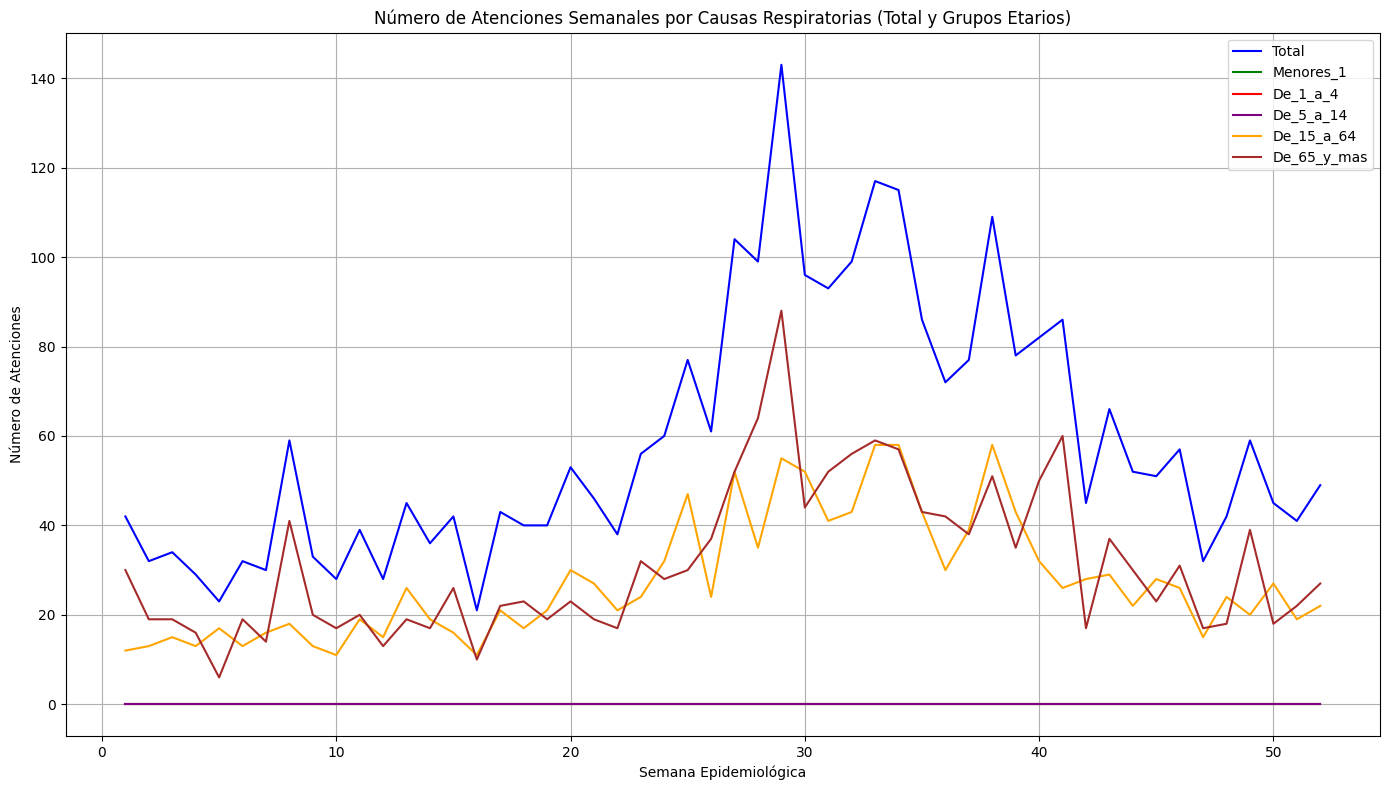


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          42          0         0          0          12           30
2          32          0         0          0          13           19
3          34          0         0          0          15           19
4          29          0         0          0          13           16
5          23          0         0          0          17            6
6          32          0         0          0          13           19
7          30          0         0          0          16           14
8          59          0         0          0          18           41
9          33          0         0          0          13           20
10         28          0         0          0          11           17
11         39          0         0          0          19           20
12         28    

In [11]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2016.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)

## 2017

### TODOS LOS DATOS

In [12]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2017.zip'
extracted_dir = 'AtencionesUrgencia2017'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2017.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2017/AtencionesUrgencia2017.csv


In [13]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2017/AtencionesUrgencia2017.csv'
ate_urg_2017 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [14]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2017.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
0,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,1,0,1,0,0,0,01/01/2017,1,Hospital,Indiferenciado,Ninguna
1,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,2,0,0,0,0,2,02/01/2017,1,Hospital,Indiferenciado,Ninguna
2,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,0,0,0,0,0,0,03/01/2017,1,Hospital,Indiferenciado,Ninguna
3,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,2,0,0,0,2,0,04/01/2017,1,Hospital,Indiferenciado,Ninguna
4,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,2,0,1,0,1,0,05/01/2017,1,Hospital,Indiferenciado,Ninguna
5,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,2,0,0,1,1,0,06/01/2017,1,Hospital,Indiferenciado,Ninguna
6,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,3,0,0,0,3,0,07/01/2017,1,Hospital,Indiferenciado,Ninguna
7,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,2,0,0,0,1,1,08/01/2017,2,Hospital,Indiferenciado,Ninguna
8,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,0,0,0,0,0,0,09/01/2017,2,Hospital,Indiferenciado,Ninguna
9,28-111,Hospital Dr. Ricardo Figueroa González (Cañete),25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,0,0,0,0,0,0,10/01/2017,2,Hospital,Indiferenciado,Ninguna


In [15]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2017)
print(f"Hay {num_filas} filas.")

Hay 4455127 filas.


### HSO

In [16]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2017[ate_urg_2017["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2017_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [17]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2017_hospital'
validar_fechas(ate_urg_2017_hospital)

📅 Fechas ordenadas en el DataFrame (año 2017):
01/01/2017
02/01/2017
03/01/2017
04/01/2017
05/01/2017
06/01/2017
07/01/2017
08/01/2017
09/01/2017
10/01/2017
11/01/2017
12/01/2017
13/01/2017
14/01/2017
15/01/2017
16/01/2017
17/01/2017
18/01/2017
19/01/2017
20/01/2017
21/01/2017
22/01/2017
23/01/2017
24/01/2017
25/01/2017
26/01/2017
27/01/2017
28/01/2017
29/01/2017
30/01/2017
31/01/2017
01/02/2017
02/02/2017
03/02/2017
04/02/2017
05/02/2017
06/02/2017
07/02/2017
08/02/2017
09/02/2017
10/02/2017
11/02/2017
12/02/2017
13/02/2017
14/02/2017
15/02/2017
16/02/2017
17/02/2017
18/02/2017
19/02/2017
20/02/2017
21/02/2017
22/02/2017
23/02/2017
24/02/2017
25/02/2017
26/02/2017
27/02/2017
28/02/2017
01/03/2017
02/03/2017
03/03/2017
04/03/2017
05/03/2017
06/03/2017
07/03/2017
08/03/2017
09/03/2017
10/03/2017
11/03/2017
12/03/2017
13/03/2017
14/03/2017
15/03/2017
16/03/2017
17/03/2017
18/03/2017
19/03/2017
20/03/2017
21/03/2017
22/03/2017
23/03/2017
24/03/2017
25/03/2017
26/03/2017
27/03/2017
28/03/2

In [18]:
# Validar número de filas
num_filas = len(ate_urg_2017_hospital)
print(f"Hay {num_filas} filas.")

Hay 9828 filas.


In [19]:
# Mostrar ejemplo de datos
ate_urg_2017_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
274317,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,7,0,0,0,6,1,01/01/2017,1,Hospital,Adulto,Adulto Metropolitana
274318,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,8,0,0,0,4,4,02/01/2017,1,Hospital,Adulto,Adulto Metropolitana
274319,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,17,0,0,0,7,10,03/01/2017,1,Hospital,Adulto,Adulto Metropolitana
274320,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,22,0,0,0,16,6,04/01/2017,1,Hospital,Adulto,Adulto Metropolitana
274321,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,18,0,0,0,10,8,05/01/2017,1,Hospital,Adulto,Adulto Metropolitana
274322,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,16,0,0,0,14,2,06/01/2017,1,Hospital,Adulto,Adulto Metropolitana
274323,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,16,0,0,0,14,2,07/01/2017,1,Hospital,Adulto,Adulto Metropolitana
274324,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,5,0,0,0,2,3,08/01/2017,2,Hospital,Adulto,Adulto Metropolitana
274360,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,12,0,0,0,6,6,09/01/2017,2,Hospital,Adulto,Adulto Metropolitana
274361,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,18,0,0,0,11,7,10/01/2017,2,Hospital,Adulto,Adulto Metropolitana


In [20]:
# Crear el DataFrame de features para el modelo del año 2017
df_features_2017 = ate_urg_2017_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2017 = df_features_2017[df_features_2017['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2017['fecha'] = pd.to_datetime(df_features_2017['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2017['año'] = df_features_2017['fecha'].dt.year
df_features_2017['mes'] = df_features_2017['fecha'].dt.month
df_features_2017['dia_del_mes'] = df_features_2017['fecha'].dt.day
df_features_2017['dia_de_la_semana'] = df_features_2017['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2017['dia_del_año'] = df_features_2017['fecha'].dt.dayofyear
df_features_2017['trimestre'] = df_features_2017['fecha'].dt.quarter
df_features_2017['fin_de_semana'] = (df_features_2017['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2017 = df_features_2017.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2017 = df_features_2017.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2017
#print("DataFrame 'df_features_2017' con nuevas características de fecha:")
df_features_2017.head()
#print("\nInformación del DataFrame 'df_features_2017':")
#df_features_2017.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2017-01-01,5,0,0,0,3,2,1,2017,1,1,6,1,1,1
2017-01-02,5,0,0,0,4,1,1,2017,1,2,0,2,1,0
2017-01-03,9,0,0,0,4,5,1,2017,1,3,1,3,1,0
2017-01-04,7,0,0,0,3,4,1,2017,1,4,2,4,1,0
2017-01-05,4,0,0,0,3,1,1,2017,1,5,3,5,1,0


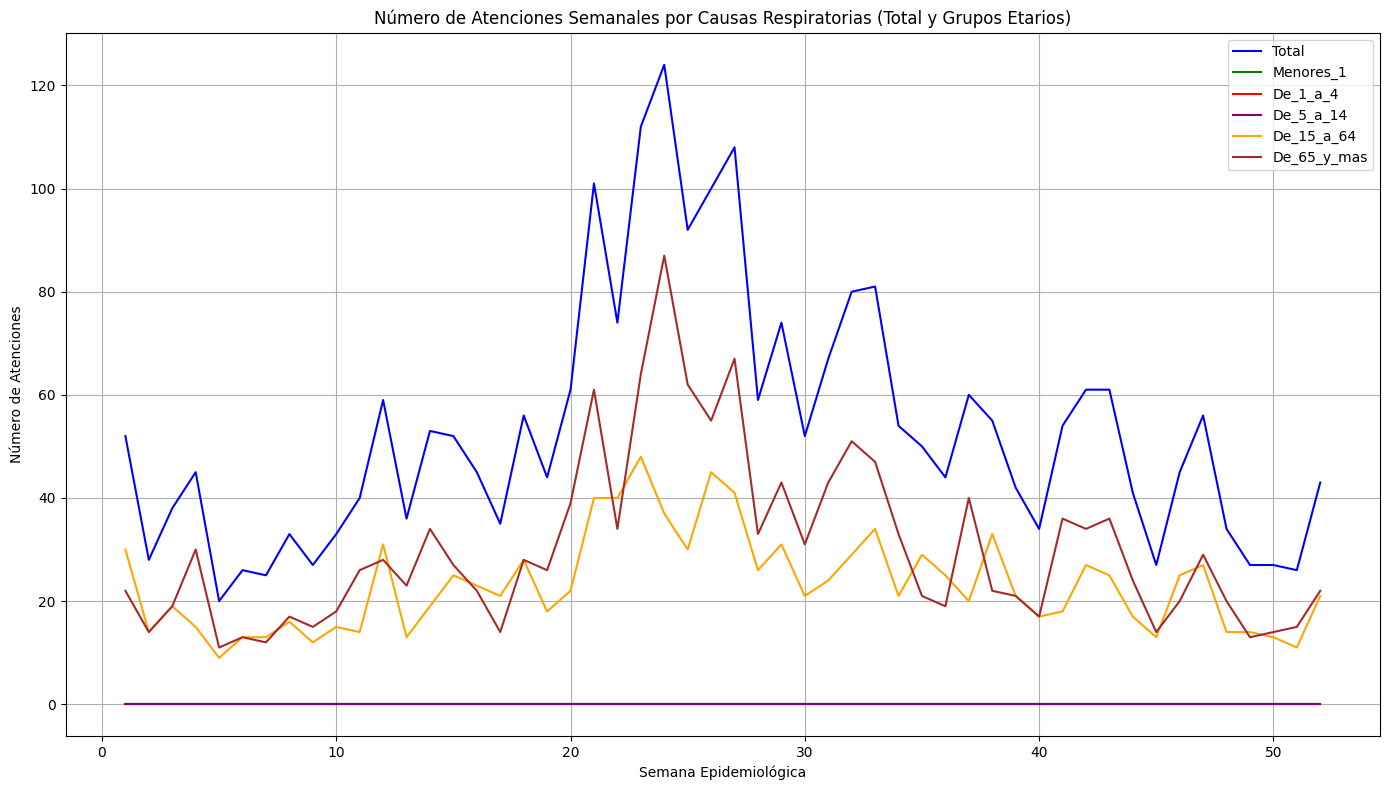


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          52          0         0          0          30           22
2          28          0         0          0          14           14
3          38          0         0          0          19           19
4          45          0         0          0          15           30
5          20          0         0          0           9           11
6          26          0         0          0          13           13
7          25          0         0          0          13           12
8          33          0         0          0          16           17
9          27          0         0          0          12           15
10         33          0         0          0          15           18
11         40          0         0          0          14           26
12         59    

In [21]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2017.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)



--- Análisis Específico 2017: IRAs por Grupo Etario ---

Total de IRAs específicas por Grupo Etario en 2017:
                                          Menores_1  De_1_a_4  De_5_a_14  \
GlosaCausa                                                                 
Bronquitis/bronquiolitis aguda (J20-J21)          0         0          0   
IRA Alta (J00-J06)                                0         0          0   
Neumonía (J12-J18)                                0         0          0   

                                          De_15_a_64  De_65_y_mas  
GlosaCausa                                                         
Bronquitis/bronquiolitis aguda (J20-J21)         129          119  
IRA Alta (J00-J06)                               318           73  
Neumonía (J12-J18)                               326          776  


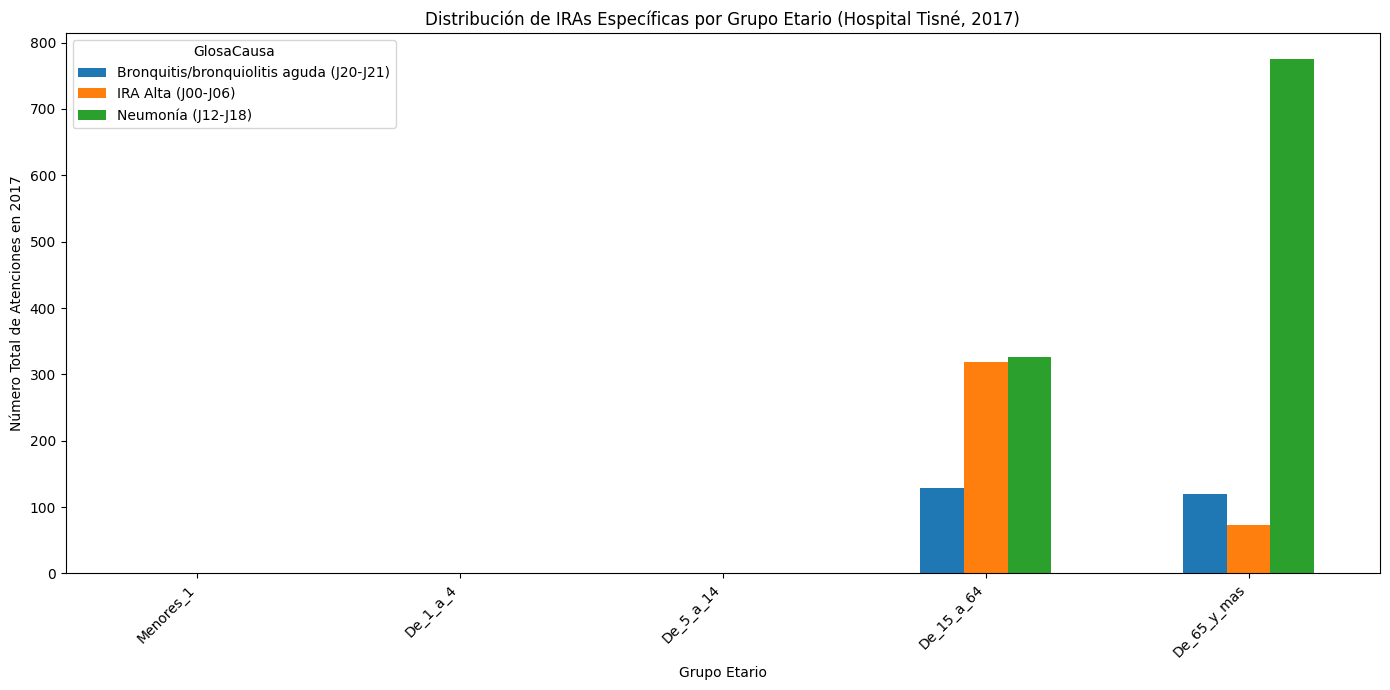

In [22]:
print("\n\n--- Análisis Específico 2017: IRAs por Grupo Etario ---")
glosas_ira_2017 = ["IRA Alta (J00-J06)", "Neumonía (J12-J18)", "Bronquitis/bronquiolitis aguda (J20-J21)"]
df_ira_2017 = ate_urg_2017_hospital[ate_urg_2017_hospital["GlosaCausa"].isin(glosas_ira_2017)].copy()

if not df_ira_2017.empty:
    columnas_edad_2017 = ['Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']
    # Asegurar que las columnas de edad existen y son numéricas
    for col_edad in columnas_edad_2017:
        if col_edad in df_ira_2017.columns:
            df_ira_2017[col_edad] = pd.to_numeric(df_ira_2017[col_edad], errors='coerce').fillna(0)
        else:
            df_ira_2017[col_edad] = 0 # Crearla con ceros si no existe para evitar errores

    total_ira_por_edad_glosa_2017 = df_ira_2017.groupby("GlosaCausa")[columnas_edad_2017].sum()
    print("\nTotal de IRAs específicas por Grupo Etario en 2017:")
    print(total_ira_por_edad_glosa_2017)

    if not total_ira_por_edad_glosa_2017.empty:
        total_ira_por_edad_glosa_2017.T.plot(kind='bar', figsize=(14,7),
                                           title="Distribución de IRAs Específicas por Grupo Etario (Hospital Tisné, 2017)")
        plt.ylabel("Número Total de Atenciones en 2017")
        plt.xlabel("Grupo Etario")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("No se encontraron datos para las IRAs especificadas en 2017.")

## 2018

### TODOS LOS DATOS

In [23]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2018.zip'
extracted_dir = 'AtencionesUrgencia2018'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2018.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2018/AtencionesUrgencia2018.csv


In [24]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2018/AtencionesUrgencia2018.csv'
ate_urg_2018 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [25]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2018.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
0,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,0,0,0,0,0,0,01/01/2018,1,SAPU,Indiferenciado,Ninguna
1,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,0,0,0,0,0,0,02/01/2018,1,SAPU,Indiferenciado,Ninguna
2,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,0,0,0,0,0,0,03/01/2018,1,SAPU,Indiferenciado,Ninguna
3,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,1,0,0,0,0,1,04/01/2018,1,SAPU,Indiferenciado,Ninguna
4,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,0,0,0,0,0,0,05/01/2018,1,SAPU,Indiferenciado,Ninguna
5,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,2,0,0,0,2,0,06/01/2018,1,SAPU,Indiferenciado,Ninguna
6,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,0,0,0,0,0,0,07/01/2018,2,SAPU,Indiferenciado,Ninguna
7,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,2,0,0,0,1,1,08/01/2018,2,SAPU,Indiferenciado,Ninguna
8,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,1,0,0,0,1,0,09/01/2018,2,SAPU,Indiferenciado,Ninguna
9,18-826,SAPU-Hualqui,12,TOTAL CAUSAS SISTEMA CIRCULATORIO,0,0,0,0,0,0,10/01/2018,2,SAPU,Indiferenciado,Ninguna


In [26]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2018)
print(f"Hay {num_filas} filas.")

Hay 4488935 filas.


### HSO

In [27]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2018[ate_urg_2018["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2018_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [28]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2018_hospital'
validar_fechas(ate_urg_2018_hospital)

📅 Fechas ordenadas en el DataFrame (año 2018):
01/01/2018
02/01/2018
03/01/2018
04/01/2018
05/01/2018
06/01/2018
07/01/2018
08/01/2018
09/01/2018
10/01/2018
11/01/2018
12/01/2018
13/01/2018
14/01/2018
16/01/2018
17/01/2018
18/01/2018
19/01/2018
20/01/2018
21/01/2018
22/01/2018
23/01/2018
24/01/2018
25/01/2018
26/01/2018
27/01/2018
28/01/2018
29/01/2018
30/01/2018
31/01/2018
01/02/2018
02/02/2018
03/02/2018
04/02/2018
05/02/2018
06/02/2018
07/02/2018
08/02/2018
09/02/2018
10/02/2018
11/02/2018
12/02/2018
13/02/2018
14/02/2018
15/02/2018
16/02/2018
18/02/2018
19/02/2018
20/02/2018
21/02/2018
22/02/2018
23/02/2018
24/02/2018
25/02/2018
26/02/2018
27/02/2018
28/02/2018
01/03/2018
02/03/2018
04/03/2018
05/03/2018
06/03/2018
07/03/2018
08/03/2018
09/03/2018
10/03/2018
11/03/2018
12/03/2018
13/03/2018
14/03/2018
15/03/2018
16/03/2018
17/03/2018
18/03/2018
19/03/2018
20/03/2018
21/03/2018
22/03/2018
23/03/2018
24/03/2018
25/03/2018
26/03/2018
27/03/2018
28/03/2018
29/03/2018
30/03/2018
31/03/2

In [29]:
# Validar número de filas
num_filas = len(ate_urg_2018_hospital)
print(f"Hay {num_filas} filas.")

Hay 9774 filas.


In [30]:
# Mostrar ejemplo de datos
ate_urg_2018_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
126138,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,18,0,0,0,11,7,01/01/2018,1,Hospital,Adulto,Adulto Metropolitana
126139,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,16,0,0,0,10,6,02/01/2018,1,Hospital,Adulto,Adulto Metropolitana
126140,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,16,0,0,0,12,4,03/01/2018,1,Hospital,Adulto,Adulto Metropolitana
126141,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,16,0,0,0,9,7,04/01/2018,1,Hospital,Adulto,Adulto Metropolitana
126163,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,0,0,0,0,0,0,05/01/2018,1,Hospital,Adulto,Adulto Metropolitana
126164,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,0,0,0,0,0,0,06/01/2018,1,Hospital,Adulto,Adulto Metropolitana
126165,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,21,0,0,0,7,14,07/01/2018,2,Hospital,Adulto,Adulto Metropolitana
126166,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,15,0,0,0,10,5,08/01/2018,2,Hospital,Adulto,Adulto Metropolitana
126167,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,17,0,0,0,9,8,09/01/2018,2,Hospital,Adulto,Adulto Metropolitana
126168,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,15,0,0,0,7,8,10/01/2018,2,Hospital,Adulto,Adulto Metropolitana


In [31]:
# Crear el DataFrame de features para el modelo del año 2018
df_features_2018 = ate_urg_2018_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2018 = df_features_2018[df_features_2018['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2018['fecha'] = pd.to_datetime(df_features_2018['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2018['año'] = df_features_2018['fecha'].dt.year
df_features_2018['mes'] = df_features_2018['fecha'].dt.month
df_features_2018['dia_del_mes'] = df_features_2018['fecha'].dt.day
df_features_2018['dia_de_la_semana'] = df_features_2018['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2018['dia_del_año'] = df_features_2018['fecha'].dt.dayofyear
df_features_2018['trimestre'] = df_features_2018['fecha'].dt.quarter
df_features_2018['fin_de_semana'] = (df_features_2018['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2018 = df_features_2018.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2018 = df_features_2018.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2018
#print("DataFrame 'df_features_2018' con nuevas características de fecha:")
df_features_2018.head()
#print("\nInformación del DataFrame 'df_features_2018':")
#df_features_2018.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2018-01-01,9,0,0,0,7,2,1,2018,1,1,0,1,1,0
2018-01-02,10,0,0,0,5,5,1,2018,1,2,1,2,1,0
2018-01-03,7,0,0,0,5,2,1,2018,1,3,2,3,1,0
2018-01-04,9,0,0,0,1,8,1,2018,1,4,3,4,1,0
2018-01-05,3,0,0,0,1,2,1,2018,1,5,4,5,1,0


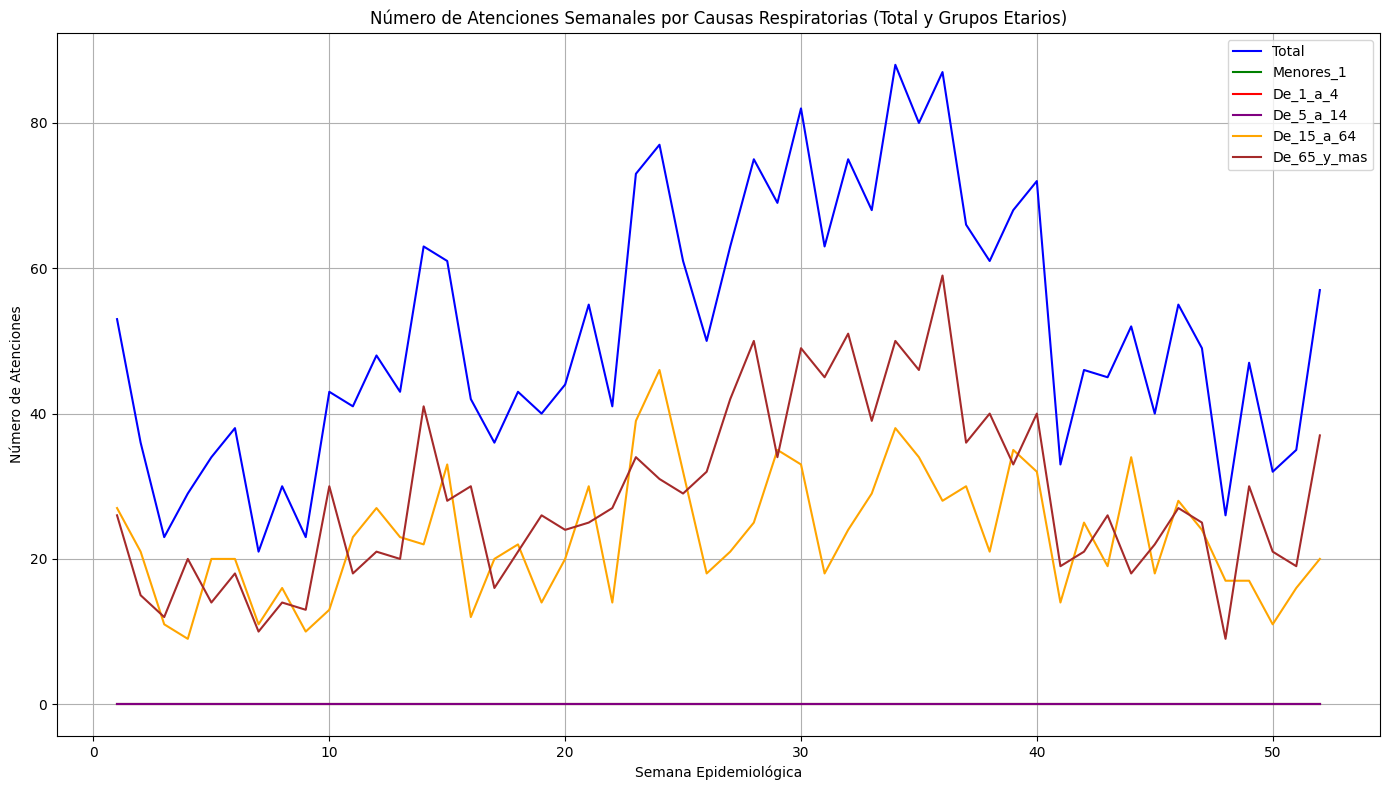


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          53          0         0          0          27           26
2          36          0         0          0          21           15
3          23          0         0          0          11           12
4          29          0         0          0           9           20
5          34          0         0          0          20           14
6          38          0         0          0          20           18
7          21          0         0          0          11           10
8          30          0         0          0          16           14
9          23          0         0          0          10           13
10         43          0         0          0          13           30
11         41          0         0          0          23           18
12         48    

In [32]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2018.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)

## 2019

### TODOS LOS DATOS

In [33]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2019.zip'
extracted_dir = 'AtencionesUrgencia2019'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2019.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2019/AtencionesUrgencia2019.csv


In [34]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2019/AtencionesUrgencia2019.csv'
ate_urg_2019 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [35]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2019.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
0,04-308,Centro de Salud Salvador Allende Gossens,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,2,0,0,0,2,0,03/08/2019,31,SAPU,Indiferenciado,Ninguna
1,04-308,Centro de Salud Salvador Allende Gossens,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,5,0,0,0,4,1,04/08/2019,32,SAPU,Indiferenciado,Ninguna
2,04-308,Centro de Salud Salvador Allende Gossens,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,12,0,3,4,5,0,05/08/2019,32,SAPU,Indiferenciado,Ninguna
3,04-308,Centro de Salud Salvador Allende Gossens,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,6,0,2,1,2,1,06/08/2019,32,SAPU,Indiferenciado,Ninguna
4,04-308,Centro de Salud Salvador Allende Gossens,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,4,0,0,1,3,0,07/08/2019,32,SAPU,Indiferenciado,Ninguna
5,04-308,Centro de Salud Salvador Allende Gossens,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,5,0,0,1,3,1,08/08/2019,32,SAPU,Indiferenciado,Ninguna
6,04-308,Centro de Salud Salvador Allende Gossens,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,3,0,1,2,0,0,09/08/2019,32,SAPU,Indiferenciado,Ninguna
7,04-308,Centro de Salud Salvador Allende Gossens,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,5,0,0,1,3,1,10/08/2019,32,SAPU,Indiferenciado,Ninguna
8,07-800,SAPU-Nueva Aurora,17,Otras causas circulatorias,0,0,0,0,0,0,17/10/2019,42,SAPU,Indiferenciado,Ninguna
9,07-800,SAPU-Nueva Aurora,17,Otras causas circulatorias,0,0,0,0,0,0,18/10/2019,42,SAPU,Indiferenciado,Ninguna


In [36]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2019)
print(f"Hay {num_filas} filas.")

Hay 4550877 filas.


### HSO

In [37]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2019[ate_urg_2019["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2019_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [38]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2019_hospital'
validar_fechas(ate_urg_2019_hospital)

📅 Fechas ordenadas en el DataFrame (año 2019):
01/01/2019
02/01/2019
03/01/2019
04/01/2019
05/01/2019
06/01/2019
07/01/2019
08/01/2019
09/01/2019
10/01/2019
11/01/2019
12/01/2019
13/01/2019
14/01/2019
15/01/2019
16/01/2019
17/01/2019
18/01/2019
19/01/2019
20/01/2019
21/01/2019
22/01/2019
23/01/2019
24/01/2019
25/01/2019
26/01/2019
27/01/2019
28/01/2019
29/01/2019
30/01/2019
31/01/2019
01/02/2019
02/02/2019
03/02/2019
04/02/2019
05/02/2019
06/02/2019
07/02/2019
08/02/2019
09/02/2019
10/02/2019
11/02/2019
12/02/2019
13/02/2019
14/02/2019
15/02/2019
16/02/2019
17/02/2019
18/02/2019
19/02/2019
20/02/2019
21/02/2019
22/02/2019
23/02/2019
24/02/2019
25/02/2019
26/02/2019
27/02/2019
28/02/2019
01/03/2019
02/03/2019
03/03/2019
04/03/2019
05/03/2019
06/03/2019
07/03/2019
08/03/2019
09/03/2019
10/03/2019
11/03/2019
12/03/2019
13/03/2019
14/03/2019
15/03/2019
16/03/2019
17/03/2019
18/03/2019
19/03/2019
20/03/2019
21/03/2019
22/03/2019
23/03/2019
24/03/2019
25/03/2019
26/03/2019
27/03/2019
28/03/2

In [39]:
# Validar número de filas
num_filas = len(ate_urg_2019_hospital)
print(f"Hay {num_filas} filas.")

Hay 9828 filas.


In [40]:
# Mostrar ejemplo de datos
ate_urg_2019_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
238727,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",2,0,0,0,0,2,23/11/2019,47,Hospital,Adulto,Adulto Metropolitana
238728,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",1,0,0,0,0,1,24/11/2019,48,Hospital,Adulto,Adulto Metropolitana
238729,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",1,0,0,0,1,0,25/11/2019,48,Hospital,Adulto,Adulto Metropolitana
238730,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",1,0,0,0,1,0,26/11/2019,48,Hospital,Adulto,Adulto Metropolitana
238731,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",3,0,0,0,1,2,27/11/2019,48,Hospital,Adulto,Adulto Metropolitana
238732,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",2,0,0,0,1,1,28/11/2019,48,Hospital,Adulto,Adulto Metropolitana
238733,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",2,0,0,0,1,1,29/11/2019,48,Hospital,Adulto,Adulto Metropolitana
238734,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",0,0,0,0,0,0,30/11/2019,48,Hospital,Adulto,Adulto Metropolitana
238735,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",1,0,0,0,1,0,01/12/2019,49,Hospital,Adulto,Adulto Metropolitana
238736,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",2,0,0,0,1,1,02/12/2019,49,Hospital,Adulto,Adulto Metropolitana


In [41]:
# Crear el DataFrame de features para el modelo del año 2019
df_features_2019 = ate_urg_2019_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2019 = df_features_2019[df_features_2019['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2019['fecha'] = pd.to_datetime(df_features_2019['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2019['año'] = df_features_2019['fecha'].dt.year
df_features_2019['mes'] = df_features_2019['fecha'].dt.month
df_features_2019['dia_del_mes'] = df_features_2019['fecha'].dt.day
df_features_2019['dia_de_la_semana'] = df_features_2019['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2019['dia_del_año'] = df_features_2019['fecha'].dt.dayofyear
df_features_2019['trimestre'] = df_features_2019['fecha'].dt.quarter
df_features_2019['fin_de_semana'] = (df_features_2019['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2019 = df_features_2019.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2019 = df_features_2019.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2019
#print("DataFrame 'df_features_2019' con nuevas características de fecha:")
df_features_2019.head()
#print("\nInformación del DataFrame 'df_features_2019':")
#df_features_2019.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2019-10-22,8,0,0,0,2,6,43,2019,10,22,1,295,4,0
2019-10-23,7,0,0,0,2,5,43,2019,10,23,2,296,4,0
2019-10-24,7,0,0,0,1,6,43,2019,10,24,3,297,4,0
2019-10-25,8,0,0,0,3,5,43,2019,10,25,4,298,4,0
2019-10-26,6,0,0,0,3,3,43,2019,10,26,5,299,4,1


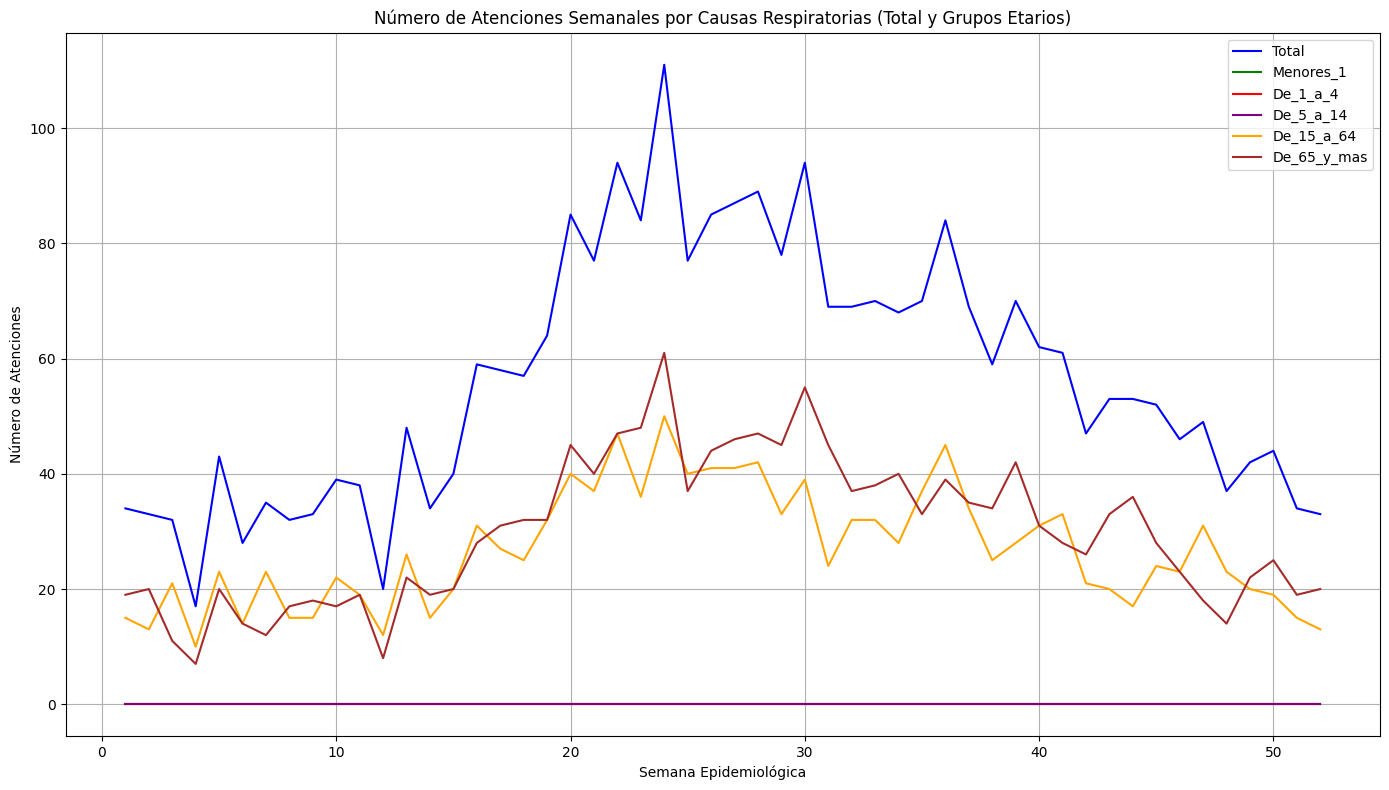


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          34          0         0          0          15           19
2          33          0         0          0          13           20
3          32          0         0          0          21           11
4          17          0         0          0          10            7
5          43          0         0          0          23           20
6          28          0         0          0          14           14
7          35          0         0          0          23           12
8          32          0         0          0          15           17
9          33          0         0          0          15           18
10         39          0         0          0          22           17
11         38          0         0          0          19           19
12         20    

In [42]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2019.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)

## 2020

### TODOS LOS DATOS

In [43]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2020.zip'
extracted_dir = 'AtencionesUrgencia2020'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2020.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2020/AtencionesUrgencia2020.csv


In [44]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2020/AtencionesUrgencia2020.csv'
ate_urg_2020 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [45]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2020.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
0,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,22,0,1,4,15,2,23/09/2020,39,SAPU,Indiferenciado,Ninguna
1,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,30,0,2,3,21,4,24/09/2020,39,SAPU,Indiferenciado,Ninguna
2,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,9,0,2,1,4,2,25/09/2020,39,SAPU,Indiferenciado,Ninguna
3,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,17,0,0,1,14,2,26/09/2020,39,SAPU,Indiferenciado,Ninguna
4,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,22,2,0,2,14,4,27/09/2020,40,SAPU,Indiferenciado,Ninguna
5,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,22,0,0,4,15,3,28/09/2020,40,SAPU,Indiferenciado,Ninguna
6,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,11,0,1,0,9,1,29/09/2020,40,SAPU,Indiferenciado,Ninguna
7,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,15,0,2,0,12,1,30/09/2020,40,SAPU,Indiferenciado,Ninguna
8,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,20,0,0,4,13,3,01/10/2020,40,SAPU,Indiferenciado,Ninguna
9,19-809,SAPU Talcahuano Sur,21,TOTAL DEMÁS CAUSAS,17,0,1,2,14,0,02/10/2020,40,SAPU,Indiferenciado,Ninguna


In [46]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2020)
print(f"Hay {num_filas} filas.")

Hay 6446646 filas.


### HSO

In [47]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2020[ate_urg_2020["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2020_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [48]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2020_hospital'
validar_fechas(ate_urg_2020_hospital)

📅 Fechas ordenadas en el DataFrame (año 2020):
01/01/2020
02/01/2020
03/01/2020
04/01/2020
05/01/2020
06/01/2020
07/01/2020
08/01/2020
09/01/2020
10/01/2020
11/01/2020
12/01/2020
13/01/2020
14/01/2020
15/01/2020
16/01/2020
17/01/2020
18/01/2020
19/01/2020
20/01/2020
21/01/2020
22/01/2020
23/01/2020
24/01/2020
25/01/2020
26/01/2020
27/01/2020
28/01/2020
29/01/2020
30/01/2020
31/01/2020
01/02/2020
02/02/2020
03/02/2020
04/02/2020
05/02/2020
06/02/2020
07/02/2020
08/02/2020
09/02/2020
10/02/2020
11/02/2020
12/02/2020
13/02/2020
14/02/2020
15/02/2020
16/02/2020
17/02/2020
18/02/2020
19/02/2020
20/02/2020
21/02/2020
22/02/2020
23/02/2020
24/02/2020
25/02/2020
26/02/2020
27/02/2020
28/02/2020
29/02/2020
01/03/2020
02/03/2020
03/03/2020
04/03/2020
05/03/2020
06/03/2020
07/03/2020
08/03/2020
09/03/2020
10/03/2020
11/03/2020
12/03/2020
13/03/2020
14/03/2020
15/03/2020
16/03/2020
17/03/2020
18/03/2020
19/03/2020
20/03/2020
21/03/2020
22/03/2020
23/03/2020
24/03/2020
25/03/2020
26/03/2020
27/03/2

In [49]:
# Validar número de filas
num_filas = len(ate_urg_2020_hospital)
print(f"Hay {num_filas} filas.")

Hay 11865 filas.


In [50]:
# Mostrar ejemplo de datos
ate_urg_2020_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
2600,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,0,0,0,0,0,0,08/09/2020,37,Hospital,Adulto,Adulto Metropolitana
2601,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,3,0,0,0,3,0,09/09/2020,37,Hospital,Adulto,Adulto Metropolitana
2602,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,2,0,0,0,2,0,10/09/2020,37,Hospital,Adulto,Adulto Metropolitana
7226,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,4,0,0,0,3,1,11/09/2020,37,Hospital,Adulto,Adulto Metropolitana
7227,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,2,0,0,0,2,0,12/09/2020,37,Hospital,Adulto,Adulto Metropolitana
7228,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,2,0,0,0,2,0,13/09/2020,38,Hospital,Adulto,Adulto Metropolitana
7229,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,2,0,0,0,2,0,14/09/2020,38,Hospital,Adulto,Adulto Metropolitana
7230,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,2,0,0,0,0,2,15/09/2020,38,Hospital,Adulto,Adulto Metropolitana
8349,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",19,Accidentes del tránsito,0,0,0,0,0,0,14/07/2020,29,Hospital,Adulto,Adulto Metropolitana
8350,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",19,Accidentes del tránsito,0,0,0,0,0,0,15/07/2020,29,Hospital,Adulto,Adulto Metropolitana


In [51]:
# Crear el DataFrame de features para el modelo del año 2020
df_features_2020 = ate_urg_2020_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2020 = df_features_2020[df_features_2020['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2020['fecha'] = pd.to_datetime(df_features_2020['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2020['año'] = df_features_2020['fecha'].dt.year
df_features_2020['mes'] = df_features_2020['fecha'].dt.month
df_features_2020['dia_del_mes'] = df_features_2020['fecha'].dt.day
df_features_2020['dia_de_la_semana'] = df_features_2020['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2020['dia_del_año'] = df_features_2020['fecha'].dt.dayofyear
df_features_2020['trimestre'] = df_features_2020['fecha'].dt.quarter
df_features_2020['fin_de_semana'] = (df_features_2020['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2020 = df_features_2020.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2020 = df_features_2020.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2020
#print("DataFrame 'df_features_2020' con nuevas características de fecha:")
df_features_2020.head()
#print("\nInformación del DataFrame 'df_features_2020':")
#df_features_2020.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2020-03-19,8,0,0,0,8,0,12,2020,3,19,3,79,1,0
2020-03-20,16,0,0,0,13,3,12,2020,3,20,4,80,1,0
2020-03-21,10,0,0,0,10,0,12,2020,3,21,5,81,1,1
2020-03-22,12,0,0,0,10,2,13,2020,3,22,6,82,1,1
2020-03-23,4,0,0,0,3,1,13,2020,3,23,0,83,1,0


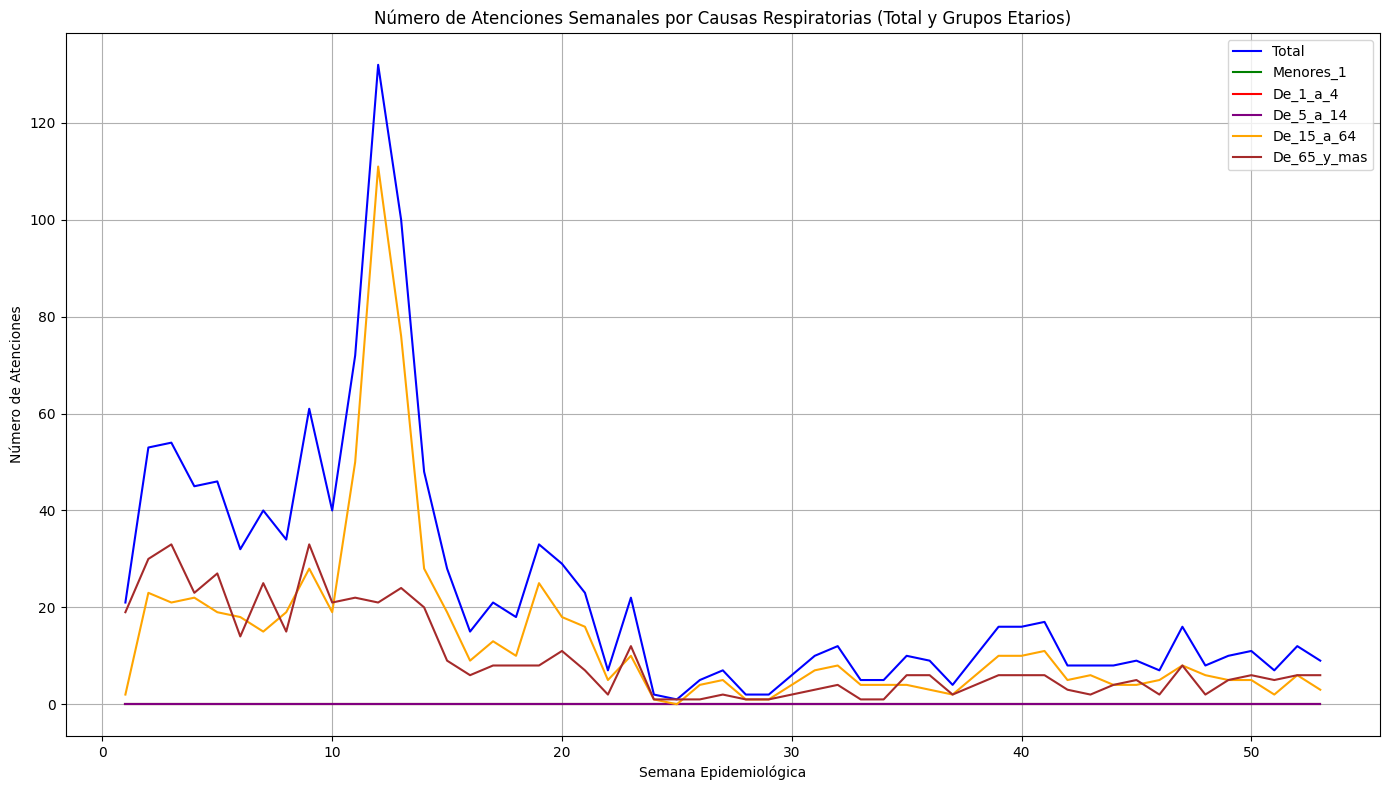


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          21          0         0          0           2           19
2          53          0         0          0          23           30
3          54          0         0          0          21           33
4          45          0         0          0          22           23
5          46          0         0          0          19           27
6          32          0         0          0          18           14
7          40          0         0          0          15           25
8          34          0         0          0          19           15
9          61          0         0          0          28           33
10         40          0         0          0          19           21
11         72          0         0          0          50           22
12        132    

In [52]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2020.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)

## 2021

### TODOS LOS DATOS

In [53]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2021.zip'
extracted_dir = 'AtencionesUrgencia2021'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2021.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2021/AtencionesUrgencia2021.csv


In [54]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2021/AtencionesUrgencia2021.csv'
ate_urg_2021 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [55]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2021.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
0,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,04/06/2021,22,SAPU,Indiferenciado,Ninguna
1,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,05/06/2021,22,SAPU,Indiferenciado,Ninguna
2,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,06/06/2021,23,SAPU,Indiferenciado,Ninguna
3,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,07/06/2021,23,SAPU,Indiferenciado,Ninguna
4,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,08/06/2021,23,SAPU,Indiferenciado,Ninguna
5,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,09/06/2021,23,SAPU,Indiferenciado,Ninguna
6,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,10/06/2021,23,SAPU,Indiferenciado,Ninguna
7,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,11/06/2021,23,SAPU,Indiferenciado,Ninguna
8,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,12/06/2021,23,SAPU,Indiferenciado,Ninguna
9,14-900,SAPU José Alvo,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,13/06/2021,24,SAPU,Indiferenciado,Ninguna


In [56]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2021)
print(f"Hay {num_filas} filas.")

Hay 8816240 filas.


### HSO

In [57]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2021[ate_urg_2021["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2021_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [58]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2021_hospital'
validar_fechas(ate_urg_2021_hospital)

📅 Fechas ordenadas en el DataFrame (año 2021):
01/01/2021
02/01/2021
03/01/2021
04/01/2021
05/01/2021
06/01/2021
07/01/2021
08/01/2021
09/01/2021
10/01/2021
11/01/2021
12/01/2021
13/01/2021
14/01/2021
15/01/2021
16/01/2021
17/01/2021
18/01/2021
19/01/2021
20/01/2021
21/01/2021
22/01/2021
23/01/2021
24/01/2021
25/01/2021
26/01/2021
27/01/2021
28/01/2021
29/01/2021
30/01/2021
31/01/2021
01/02/2021
02/02/2021
03/02/2021
04/02/2021
05/02/2021
06/02/2021
07/02/2021
08/02/2021
09/02/2021
10/02/2021
11/02/2021
12/02/2021
13/02/2021
14/02/2021
15/02/2021
16/02/2021
17/02/2021
18/02/2021
19/02/2021
20/02/2021
21/02/2021
22/02/2021
23/02/2021
24/02/2021
25/02/2021
26/02/2021
27/02/2021
28/02/2021
01/03/2021
02/03/2021
03/03/2021
04/03/2021
05/03/2021
06/03/2021
07/03/2021
08/03/2021
09/03/2021
10/03/2021
11/03/2021
12/03/2021
13/03/2021
14/03/2021
15/03/2021
16/03/2021
17/03/2021
18/03/2021
19/03/2021
20/03/2021
21/03/2021
22/03/2021
23/03/2021
24/03/2021
25/03/2021
26/03/2021
27/03/2021
28/03/2

In [59]:
# Validar número de filas
num_filas = len(ate_urg_2021_hospital)
print(f"Hay {num_filas} filas.")

Hay 14600 filas.


In [60]:
# Mostrar ejemplo de datos
ate_urg_2021_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
2134,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,3,0,0,0,0,3,31/01/2021,5,Hospital,Adulto,Adulto Metropolitana
2135,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,10,0,0,0,4,6,01/02/2021,5,Hospital,Adulto,Adulto Metropolitana
2136,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,2,0,0,0,1,1,02/02/2021,5,Hospital,Adulto,Adulto Metropolitana
2137,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,8,0,0,0,2,6,03/02/2021,5,Hospital,Adulto,Adulto Metropolitana
2138,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,6,0,0,0,2,4,04/02/2021,5,Hospital,Adulto,Adulto Metropolitana
2151,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,8,0,0,0,6,2,21/01/2021,3,Hospital,Adulto,Adulto Metropolitana
2152,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,8,0,0,0,5,3,22/01/2021,3,Hospital,Adulto,Adulto Metropolitana
2153,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,6,0,0,0,3,3,23/01/2021,3,Hospital,Adulto,Adulto Metropolitana
2172,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,7,0,0,0,4,3,12/02/2021,6,Hospital,Adulto,Adulto Metropolitana
2173,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",12,TOTAL CAUSAS SISTEMA CIRCULATORIO,5,0,0,0,1,4,13/02/2021,6,Hospital,Adulto,Adulto Metropolitana


In [61]:
# Crear el DataFrame de features para el modelo del año 2021
df_features_2021 = ate_urg_2021_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2021 = df_features_2021[df_features_2021['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2021['fecha'] = pd.to_datetime(df_features_2021['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2021['año'] = df_features_2021['fecha'].dt.year
df_features_2021['mes'] = df_features_2021['fecha'].dt.month
df_features_2021['dia_del_mes'] = df_features_2021['fecha'].dt.day
df_features_2021['dia_de_la_semana'] = df_features_2021['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2021['dia_del_año'] = df_features_2021['fecha'].dt.dayofyear
df_features_2021['trimestre'] = df_features_2021['fecha'].dt.quarter
df_features_2021['fin_de_semana'] = (df_features_2021['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2021 = df_features_2021.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2021 = df_features_2021.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2021
#print("DataFrame 'df_features_2021' con nuevas características de fecha:")
df_features_2021.head()
#print("\nInformación del DataFrame 'df_features_2021':")
#df_features_2021.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2021-03-26,0,0,0,0,0,0,12,2021,3,26,4,85,1,0
2021-03-27,0,0,0,0,0,0,12,2021,3,27,5,86,1,1
2021-03-28,0,0,0,0,0,0,13,2021,3,28,6,87,1,1
2021-03-29,1,0,0,0,1,0,13,2021,3,29,0,88,1,0
2021-03-30,0,0,0,0,0,0,13,2021,3,30,1,89,1,0


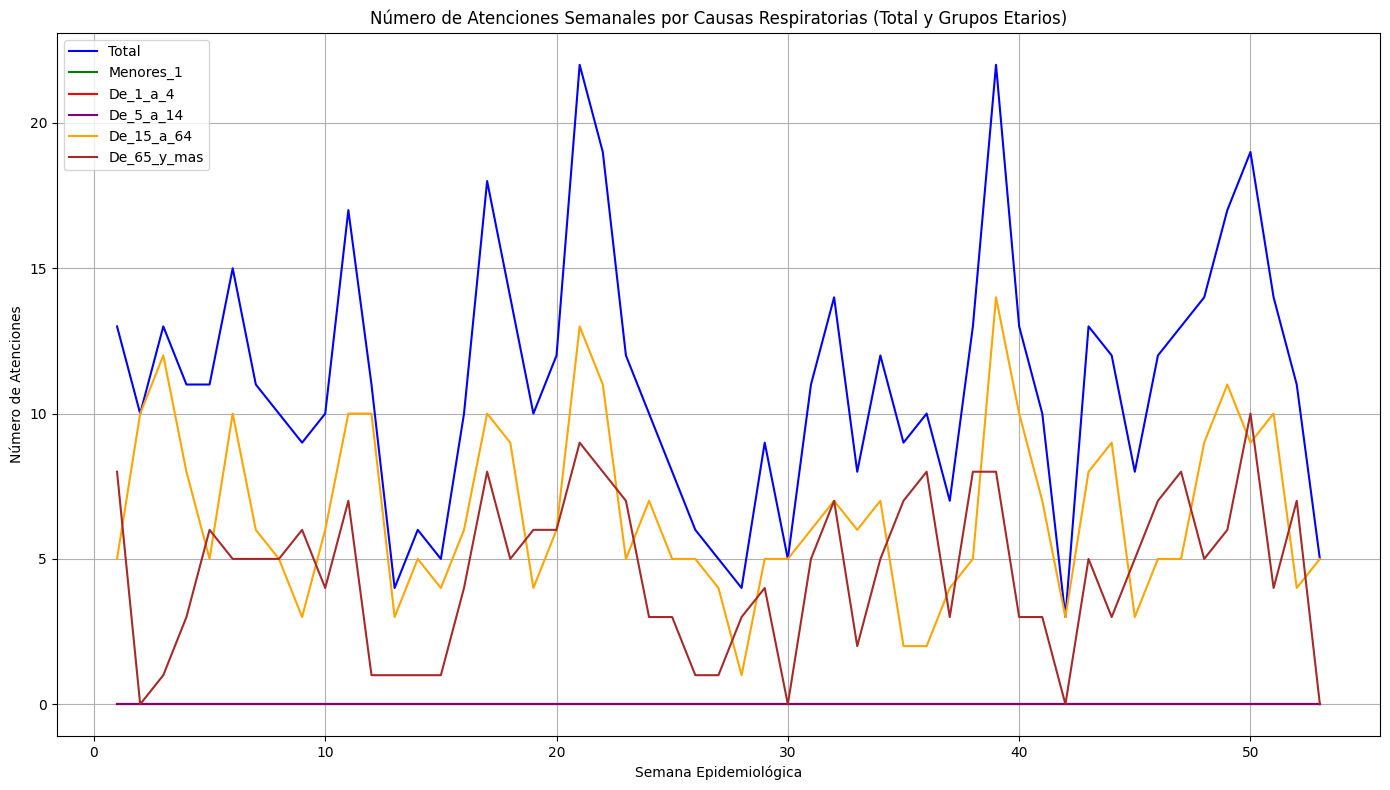


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          13          0         0          0           5            8
2          10          0         0          0          10            0
3          13          0         0          0          12            1
4          11          0         0          0           8            3
5          11          0         0          0           5            6
6          15          0         0          0          10            5
7          11          0         0          0           6            5
8          10          0         0          0           5            5
9           9          0         0          0           3            6
10         10          0         0          0           6            4
11         17          0         0          0          10            7
12         11    

In [62]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2021.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)

## 2022

### TODOS LOS DATOS

In [63]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2022.zip'
extracted_dir = 'AtencionesUrgencia2022'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2022.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2022/AtencionesUrgencia2022.csv


In [64]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2022/AtencionesUrgencia2022.csv'
ate_urg_2022 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [65]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2022.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
0,18-106,Hospital de Lota,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,68,1,3,10,43,11,01/01/2022,52,Hospital,Indiferenciado,Ninguna
1,03-910,SAR Alemania,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,80,1,5,10,55,9,01/01/2022,52,SAR,Indiferenciado,Ninguna
2,14-822,SAR Padre Manuel Villaseca,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,121,2,8,14,77,20,01/01/2022,52,SAR,Indiferenciado,Ninguna
3,11-903,SAR Enfermera Sofía Pincheira,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,110,0,5,11,77,17,01/01/2022,52,SAR,Indiferenciado,Ninguna
4,13-814,SAPU Cóndores de Chile,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,89,0,4,8,63,14,01/01/2022,52,SAPU,Indiferenciado,Sapu Metropolitana
5,06-904,SAR Plan de Valparaíso,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,95,0,1,1,72,21,01/01/2022,52,SAR,Indiferenciado,Ninguna
6,201078,"SAPU CESFAM O""HIGGINS",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,2,0,6,1,01/01/2022,52,SAPU,Indiferenciado,Ninguna
7,18-814,SAPU-Leonera,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,72,1,7,10,46,8,01/01/2022,52,SAPU,Indiferenciado,Ninguna
8,10-918,SAPU El Monte,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,83,3,7,9,56,8,01/01/2022,52,SAPU,Indiferenciado,Ninguna
9,18-810,SAPU Juan Soto Fernández,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,44,3,2,6,28,5,01/01/2022,52,SAPU,Indiferenciado,Ninguna


In [66]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2022)
print(f"Hay {num_filas} filas.")

Hay 8926307 filas.


### HSO

In [67]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2022[ate_urg_2022["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2022_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [68]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2022_hospital'
validar_fechas(ate_urg_2022_hospital)

📅 Fechas ordenadas en el DataFrame (año 2022):
01/01/2022
02/01/2022
03/01/2022
04/01/2022
05/01/2022
06/01/2022
07/01/2022
08/01/2022
09/01/2022
10/01/2022
11/01/2022
12/01/2022
13/01/2022
14/01/2022
15/01/2022
16/01/2022
17/01/2022
18/01/2022
19/01/2022
20/01/2022
21/01/2022
22/01/2022
23/01/2022
24/01/2022
25/01/2022
26/01/2022
27/01/2022
28/01/2022
29/01/2022
30/01/2022
31/01/2022
01/02/2022
02/02/2022
03/02/2022
04/02/2022
05/02/2022
06/02/2022
07/02/2022
08/02/2022
09/02/2022
10/02/2022
11/02/2022
12/02/2022
13/02/2022
14/02/2022
15/02/2022
16/02/2022
17/02/2022
18/02/2022
19/02/2022
20/02/2022
21/02/2022
22/02/2022
23/02/2022
24/02/2022
25/02/2022
26/02/2022
27/02/2022
28/02/2022
01/03/2022
02/03/2022
03/03/2022
04/03/2022
05/03/2022
06/03/2022
07/03/2022
08/03/2022
09/03/2022
10/03/2022
11/03/2022
12/03/2022
13/03/2022
14/03/2022
15/03/2022
16/03/2022
17/03/2022
18/03/2022
19/03/2022
20/03/2022
21/03/2022
22/03/2022
23/03/2022
24/03/2022
25/03/2022
26/03/2022
27/03/2022
28/03/2

In [69]:
# Validar número de filas
num_filas = len(ate_urg_2022_hospital)
print(f"Hay {num_filas} filas.")

Hay 14600 filas.


In [70]:
# Mostrar ejemplo de datos
ate_urg_2022_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
403,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,105,0,0,0,82,23,02/01/2022,1,Hospital,Adulto,Adulto Metropolitana
567,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,95,0,0,0,61,34,08/01/2022,1,Hospital,Adulto,Adulto Metropolitana
1138,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",4,Influenza (J09-J11),0,0,0,0,0,0,18/06/2022,24,Hospital,Adulto,Adulto Metropolitana
2077,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,99,0,0,0,71,28,03/01/2022,1,Hospital,Adulto,Adulto Metropolitana
3353,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,100,0,0,0,65,35,04/01/2022,1,Hospital,Adulto,Adulto Metropolitana
4583,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,101,0,0,0,72,29,05/01/2022,1,Hospital,Adulto,Adulto Metropolitana
5192,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",3,Bronquitis/bronquiolitis aguda (J20-J21),1,0,0,0,1,0,28/09/2022,39,Hospital,Adulto,Adulto Metropolitana
5671,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,96,0,0,0,70,26,16/01/2022,3,Hospital,Adulto,Adulto Metropolitana
6239,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",3,Bronquitis/bronquiolitis aguda (J20-J21),0,0,0,0,0,0,20/02/2022,8,Hospital,Adulto,Adulto Metropolitana
6349,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,124,0,0,0,93,31,06/01/2022,1,Hospital,Adulto,Adulto Metropolitana


In [71]:
# Crear el DataFrame de features para el modelo del año 2022
df_features_2022 = ate_urg_2022_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2022 = df_features_2022[df_features_2022['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2022['fecha'] = pd.to_datetime(df_features_2022['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2022['año'] = df_features_2022['fecha'].dt.year
df_features_2022['mes'] = df_features_2022['fecha'].dt.month
df_features_2022['dia_del_mes'] = df_features_2022['fecha'].dt.day
df_features_2022['dia_de_la_semana'] = df_features_2022['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2022['dia_del_año'] = df_features_2022['fecha'].dt.dayofyear
df_features_2022['trimestre'] = df_features_2022['fecha'].dt.quarter
df_features_2022['fin_de_semana'] = (df_features_2022['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2022 = df_features_2022.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2022 = df_features_2022.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2022
#print("DataFrame 'df_features_2022' con nuevas características de fecha:")
df_features_2022.head()
#print("\nInformación del DataFrame 'df_features_2022':")
#df_features_2022.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2022-05-16,6,0,0,0,3,3,20,2022,5,16,0,136,2,0
2022-05-31,10,0,0,0,8,2,22,2022,5,31,1,151,2,0
2022-10-01,3,0,0,0,3,0,39,2022,10,1,5,274,4,1
2022-12-09,7,0,0,0,4,3,49,2022,12,9,4,343,4,0
2022-12-14,10,0,0,0,7,3,50,2022,12,14,2,348,4,0


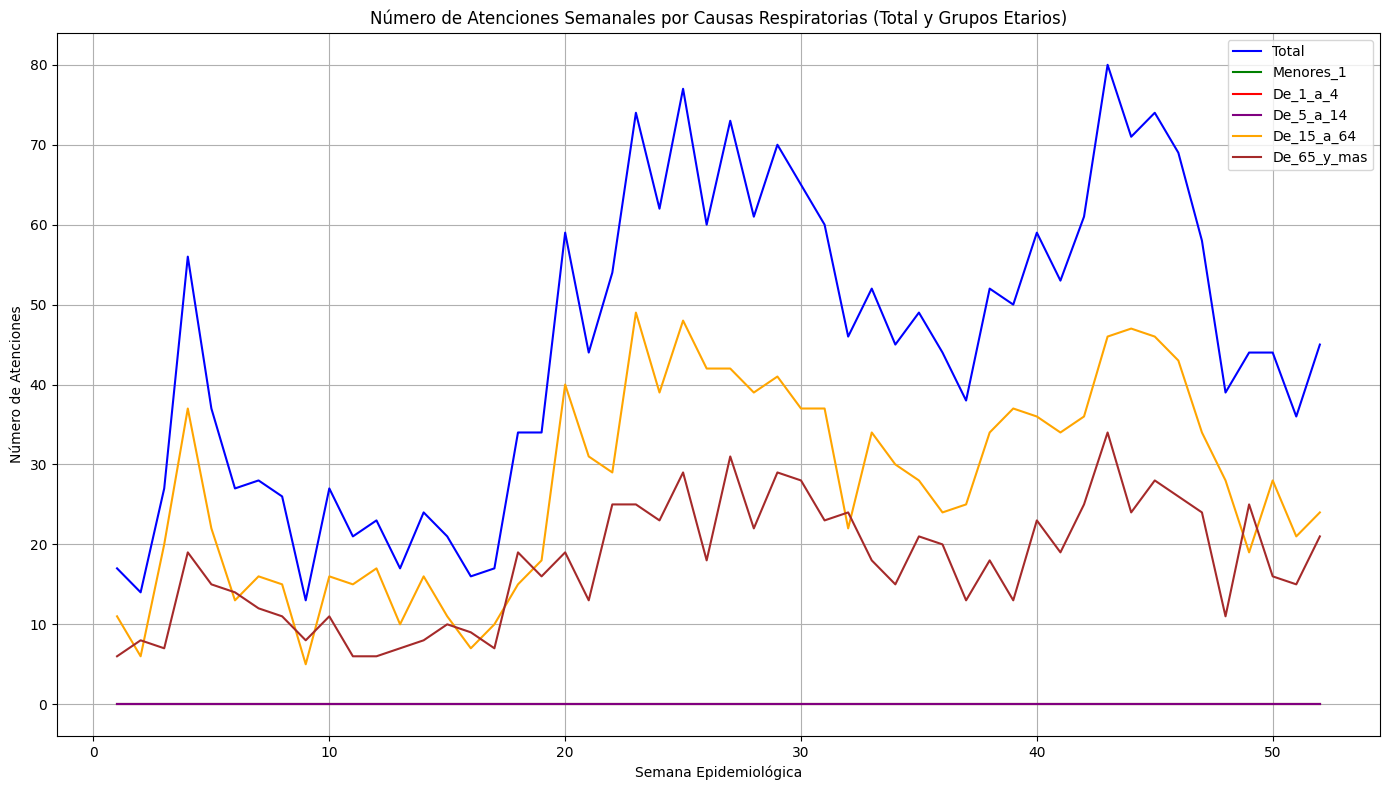


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          17          0         0          0          11            6
2          14          0         0          0           6            8
3          27          0         0          0          20            7
4          56          0         0          0          37           19
5          37          0         0          0          22           15
6          27          0         0          0          13           14
7          28          0         0          0          16           12
8          26          0         0          0          15           11
9          13          0         0          0           5            8
10         27          0         0          0          16           11
11         21          0         0          0          15            6
12         23    

In [72]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2022.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)

## 2023

### TODOS LOS DATOS

In [1]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2023.zip'
extracted_dir = 'AtencionesUrgencia2023'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2023.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2023/AtencionesUrgencia2023.csv


In [2]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2023/AtencionesUrgencia2023.csv'
ate_urg_2023 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [3]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2023.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,...,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,CodigoRegion,NombreRegion,CodigoDependencia,NombreDependencia,CodigoComuna,NombreComuna
0,23-985,SAPU Dr. Marcelo Lopetegui Adams,40,"Trastornos neuróticos, trastornos relacionados...",3,0,0,0,2,1,...,27,SAPU,Indiferenciado,Ninguna,10,De Los Lagos,23,Osorno,10301,Osorno
1,21-109,Hospital Dr. Hernán Henríquez Aravena (Temuco),40,"Trastornos neuróticos, trastornos relacionados...",1,0,0,0,1,0,...,27,Hospital,Indiferenciado,Invierno Regiones,9,De La Araucanía,21,Araucanía Sur,9101,Temuco
2,13-920,SUR Los Bajos de San Agustín,40,"Trastornos neuróticos, trastornos relacionados...",1,0,0,0,1,0,...,27,SUR,Indiferenciado,Ninguna,13,Metropolitana de Santiago,13,Metropolitano Sur,13403,Calera de Tango
3,03-910,SAR Alemania,40,"Trastornos neuróticos, trastornos relacionados...",0,0,0,0,0,0,...,27,SAR,Indiferenciado,Ninguna,2,De Antofagasta,3,Antofagasta,2201,Calama
4,16-107,Hospital de Constitución,40,"Trastornos neuróticos, trastornos relacionados...",0,0,0,0,0,0,...,27,Hospital,Indiferenciado,Ninguna,7,Del Maule,16,Del Maule,7102,Constitución
5,06-829,SAR Nestor Fernández Thomas,40,"Trastornos neuróticos, trastornos relacionados...",0,0,0,0,0,0,...,27,SAR,Indiferenciado,Ninguna,5,De Valparaíso,6,Valparaíso San Antonio,5601,San Antonio
6,21-920,SAR Lautaro,37,Ideación Suicida (R45.8),0,0,0,0,0,0,...,27,SAR,Indiferenciado,Ninguna,9,De La Araucanía,21,Araucanía Sur,9108,Lautaro
7,20-103,Hospital de Nacimiento,37,Ideación Suicida (R45.8),0,0,0,0,0,0,...,27,Hospital,Indiferenciado,Ninguna,8,Del Bíobío,20,Bíobío,8306,Nacimiento
8,22-921,SUR Coñaripe,37,Ideación Suicida (R45.8),0,0,0,0,0,0,...,27,SUR,Indiferenciado,Ninguna,14,De Los Ríos,22,Valdivia,14108,Panguipulli
9,08-101,Hospital San Juan de Dios (Los Andes),37,Ideación Suicida (R45.8),0,0,0,0,0,0,...,27,Hospital,Indiferenciado,Ninguna,5,De Valparaíso,8,Aconcagua,5301,Los Andes


In [4]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2023)
print(f"Hay {num_filas} filas.")

Hay 8899080 filas.


### HSO

In [5]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2023[ate_urg_2023["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2023_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [6]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2023_hospital'
validar_fechas(ate_urg_2023_hospital)

📅 Fechas ordenadas en el DataFrame (año 2023):
01/01/2023
02/01/2023
03/01/2023
04/01/2023
05/01/2023
06/01/2023
07/01/2023
08/01/2023
09/01/2023
10/01/2023
11/01/2023
12/01/2023
13/01/2023
14/01/2023
15/01/2023
16/01/2023
17/01/2023
18/01/2023
19/01/2023
20/01/2023
21/01/2023
22/01/2023
23/01/2023
24/01/2023
25/01/2023
26/01/2023
27/01/2023
28/01/2023
29/01/2023
30/01/2023
31/01/2023
01/02/2023
02/02/2023
03/02/2023
04/02/2023
05/02/2023
06/02/2023
07/02/2023
08/02/2023
09/02/2023
10/02/2023
11/02/2023
12/02/2023
13/02/2023
14/02/2023
15/02/2023
16/02/2023
17/02/2023
18/02/2023
19/02/2023
20/02/2023
21/02/2023
22/02/2023
23/02/2023
24/02/2023
25/02/2023
26/02/2023
27/02/2023
28/02/2023
01/03/2023
02/03/2023
03/03/2023
04/03/2023
05/03/2023
06/03/2023
07/03/2023
08/03/2023
09/03/2023
10/03/2023
11/03/2023
12/03/2023
13/03/2023
14/03/2023
15/03/2023
16/03/2023
17/03/2023
18/03/2023
19/03/2023
20/03/2023
21/03/2023
22/03/2023
23/03/2023
24/03/2023
25/03/2023
26/03/2023
27/03/2023
28/03/2

In [7]:
# Validar número de filas
num_filas = len(ate_urg_2023_hospital)
print(f"Hay {num_filas} filas.")

Hay 14600 filas.


In [8]:
# Mostrar ejemplo de datos
ate_urg_2023_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,...,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,CodigoRegion,NombreRegion,CodigoDependencia,NombreDependencia,CodigoComuna,NombreComuna
2318,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",0,0,0,0,0,0,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
2481,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",13,Infarto agudo miocardio,0,0,0,0,0,0,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
2752,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",20,Otras causas externas,1,0,0,0,0,1,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
2969,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",20,Otras causas externas,3,0,0,0,2,1,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
3096,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",33,"- COVID-19, VIRUS NO IDENTIFICADO U07.2",0,0,0,0,0,0,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
3160,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",42,- CAUSAS POR TRASTORNOS MENTALES (F00-F99),0,0,0,0,0,0,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
3269,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",24,CIRUGÍAS DE URGENCIA,5,0,0,0,5,0,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
4826,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",33,"- COVID-19, VIRUS NO IDENTIFICADO U07.2",0,0,0,0,0,0,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
4949,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",42,- CAUSAS POR TRASTORNOS MENTALES (F00-F99),0,0,0,0,0,0,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén
5271,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",24,CIRUGÍAS DE URGENCIA,3,0,0,0,0,3,...,27,Hospital,Adulto,Adulto Metropolitana,13,Metropolitana de Santiago,12,Metropolitano Oriente,13122,Peñalolén


In [9]:
# Crear el DataFrame de features para el modelo del año 2023
df_features_2023 = ate_urg_2023_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2023 = df_features_2023[df_features_2023['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2023['fecha'] = pd.to_datetime(df_features_2023['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2023['año'] = df_features_2023['fecha'].dt.year
df_features_2023['mes'] = df_features_2023['fecha'].dt.month
df_features_2023['dia_del_mes'] = df_features_2023['fecha'].dt.day
df_features_2023['dia_de_la_semana'] = df_features_2023['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2023['dia_del_año'] = df_features_2023['fecha'].dt.dayofyear
df_features_2023['trimestre'] = df_features_2023['fecha'].dt.quarter
df_features_2023['fin_de_semana'] = (df_features_2023['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2023 = df_features_2023.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2023 = df_features_2023.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2023
#print("DataFrame 'df_features_2023' con nuevas características de fecha:")
df_features_2023.head()
#print("\nInformación del DataFrame 'df_features_2023':")
#df_features_2023.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2023-07-05,13,0,0,0,5,8,27,2023,7,5,2,186,3,0
2023-07-06,7,0,0,0,4,3,27,2023,7,6,3,187,3,0
2023-07-09,5,0,0,0,2,3,28,2023,7,9,6,190,3,1
2023-07-08,11,0,0,0,5,6,27,2023,7,8,5,189,3,1
2023-07-11,10,0,0,0,6,4,28,2023,7,11,1,192,3,0


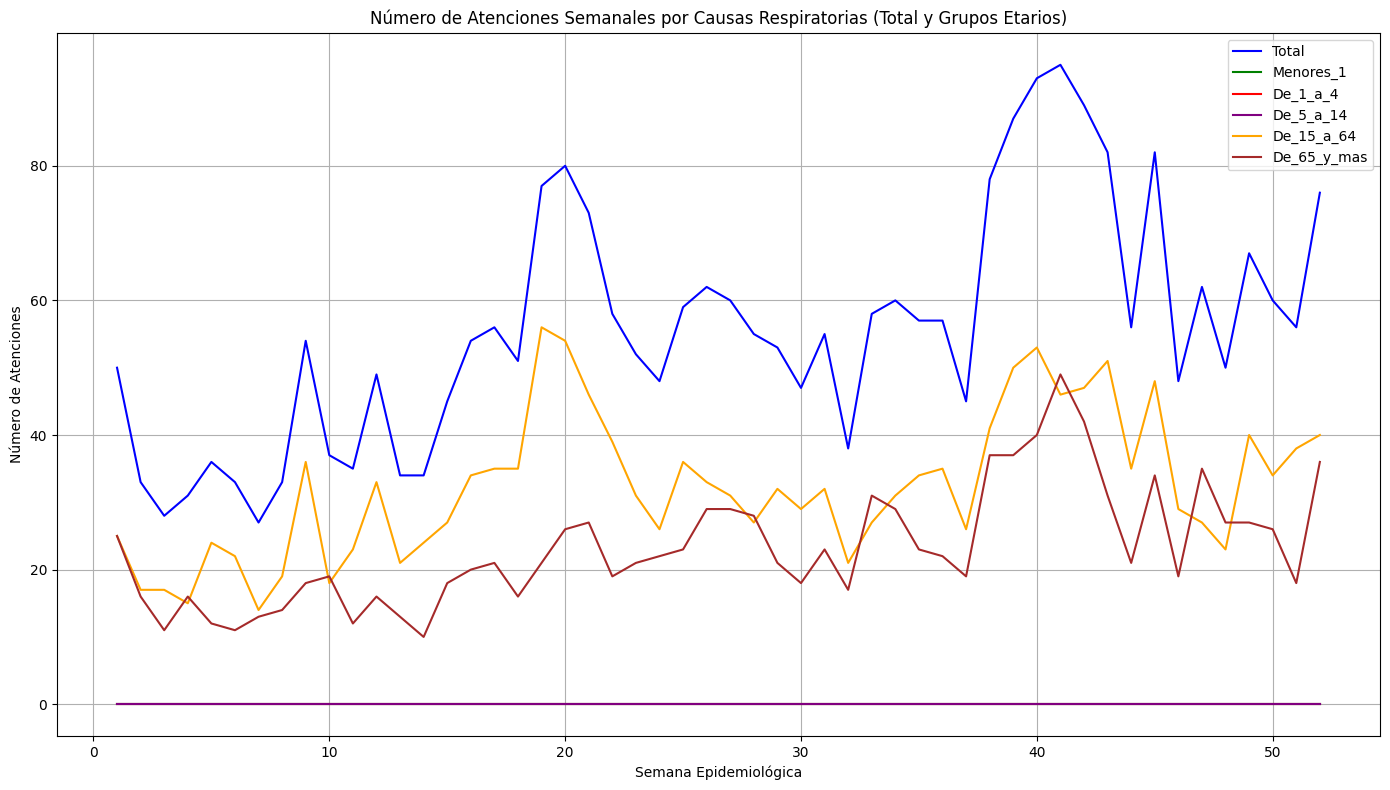


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          50          0         0          0          25           25
2          33          0         0          0          17           16
3          28          0         0          0          17           11
4          31          0         0          0          15           16
5          36          0         0          0          24           12
6          33          0         0          0          22           11
7          27          0         0          0          14           13
8          33          0         0          0          19           14
9          54          0         0          0          36           18
10         37          0         0          0          18           19
11         35          0         0          0          23           12
12         49    

In [10]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2023.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)

## 2024

### TODOS LOS DATOS

In [11]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2024.zip'
extracted_dir = 'AtencionesUrgencia2024'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2024.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2024/AtencionesUrgencia2024.csv


In [12]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2024/AtencionesUrgencia2024.csv'
ate_urg_2024 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

<ipython-input-12-e5706b01daf3>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ate_urg_2024 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')


In [13]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2024.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,...,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,CodigoRegion,NombreRegion,CodigoDependencia,NombreDependencia,CodigoComuna,NombreComuna
0,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),15,Crisis hipertensiva,4,0,0,0,1,3,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
1,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),16,Arritmia grave,0,0,0,0,0,0,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
2,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),17,Otras causas circulatorias,8,0,0,0,3,5,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
3,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,54,1,4,6,29,14,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
4,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),19,Accidentes del tránsito,4,0,0,0,4,0,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
5,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),35,Lesiones autoinfligidas intencionalmente (X60-...,0,0,0,0,0,0,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
6,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),20,Otras causas externas,50,1,4,6,25,14,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
7,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),36,TOTAL CAUSAS DE TRASTORNOS MENTALES (F00-F99),11,0,0,0,7,4,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
8,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),37,Ideación Suicida (R45.8),0,0,0,0,0,0,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica
9,01-100,Hospital Regional Dr. Juan Noé Crevani (Arica),38,Trastornos mentales y del comportamiento debid...,2,0,0,0,2,0,...,1,Hospital,Indiferenciado,Ninguna,15.0,De Arica y Parinacota,1.0,Arica,15101.0,Arica


In [14]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2024)
print(f"Hay {num_filas} filas.")

Hay 8973229 filas.


### HSO

In [15]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2024[ate_urg_2024["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2024_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [16]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2024_hospital'
validar_fechas(ate_urg_2024_hospital)

📅 Fechas ordenadas en el DataFrame (año 2024):
01/01/2024
02/01/2024
03/01/2024
04/01/2024
05/01/2024
06/01/2024
07/01/2024
08/01/2024
09/01/2024
10/01/2024
11/01/2024
12/01/2024
13/01/2024
14/01/2024
15/01/2024
16/01/2024
17/01/2024
18/01/2024
19/01/2024
20/01/2024
21/01/2024
22/01/2024
23/01/2024
24/01/2024
25/01/2024
26/01/2024
27/01/2024
28/01/2024
29/01/2024
30/01/2024
31/01/2024
01/02/2024
02/02/2024
03/02/2024
04/02/2024
05/02/2024
06/02/2024
07/02/2024
08/02/2024
09/02/2024
10/02/2024
11/02/2024
12/02/2024
13/02/2024
14/02/2024
15/02/2024
16/02/2024
17/02/2024
18/02/2024
19/02/2024
20/02/2024
21/02/2024
22/02/2024
23/02/2024
24/02/2024
25/02/2024
26/02/2024
27/02/2024
28/02/2024
29/02/2024
01/03/2024
02/03/2024
03/03/2024
04/03/2024
05/03/2024
06/03/2024
07/03/2024
08/03/2024
09/03/2024
10/03/2024
11/03/2024
12/03/2024
13/03/2024
14/03/2024
15/03/2024
16/03/2024
17/03/2024
18/03/2024
19/03/2024
20/03/2024
21/03/2024
22/03/2024
23/03/2024
24/03/2024
25/03/2024
26/03/2024
27/03/2

In [17]:
# Validar número de filas
num_filas = len(ate_urg_2024_hospital)
print(f"Hay {num_filas} filas.")

Hay 14640 filas.


In [18]:
# Mostrar ejemplo de datos
ate_urg_2024_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,...,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,CodigoRegion,NombreRegion,CodigoDependencia,NombreDependencia,CodigoComuna,NombreComuna
3025388,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",34,TOTAL DEMANDA,110,0,0,0,69,41,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025389,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,103,0,0,0,62,41,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025390,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",2,TOTAL CAUSAS SISTEMA RESPIRATORIO,11,0,0,0,4,7,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025391,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",10,IRA Alta (J00-J06),2,0,0,0,1,1,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025392,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",4,Influenza (J09-J11),0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025393,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",5,Neumonía (J12-J18),5,0,0,0,2,3,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025394,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",3,Bronquitis/bronquiolitis aguda (J20-J21),0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025395,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",11,Crisis obstructiva bronquial (J40-J46),4,0,0,0,1,3,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025396,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
3025397,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",31,"Covid-19, Virus no identificado U07.2",0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén


In [19]:
# Crear el DataFrame de features para el modelo del año 2024
df_features_2024 = ate_urg_2024_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2024 = df_features_2024[df_features_2024['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2024['fecha'] = pd.to_datetime(df_features_2024['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2024['año'] = df_features_2024['fecha'].dt.year
df_features_2024['mes'] = df_features_2024['fecha'].dt.month
df_features_2024['dia_del_mes'] = df_features_2024['fecha'].dt.day
df_features_2024['dia_de_la_semana'] = df_features_2024['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2024['dia_del_año'] = df_features_2024['fecha'].dt.dayofyear
df_features_2024['trimestre'] = df_features_2024['fecha'].dt.quarter
df_features_2024['fin_de_semana'] = (df_features_2024['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2024 = df_features_2024.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2024 = df_features_2024.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2024
print("DataFrame 'df_features_2024' con nuevas características de fecha:")
print(df_features_2024.head())
print("\nInformación del DataFrame 'df_features_2024':")
df_features_2024.info()

DataFrame 'df_features_2024' con nuevas características de fecha:
            Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas  \
fecha                                                                        
2024-01-01     11          0         0          0           4            7   
2024-01-02     10          0         0          0           2            8   
2024-01-03     10          0         0          0           6            4   
2024-01-04     11          0         0          0           6            5   
2024-01-05      7          0         0          0           2            5   

            semana   año  mes  dia_del_mes  dia_de_la_semana  dia_del_año  \
fecha                                                                       
2024-01-01       1  2024    1            1                 0            1   
2024-01-02       1  2024    1            2                 1            2   
2024-01-03       1  2024    1            3                 2            3   
20

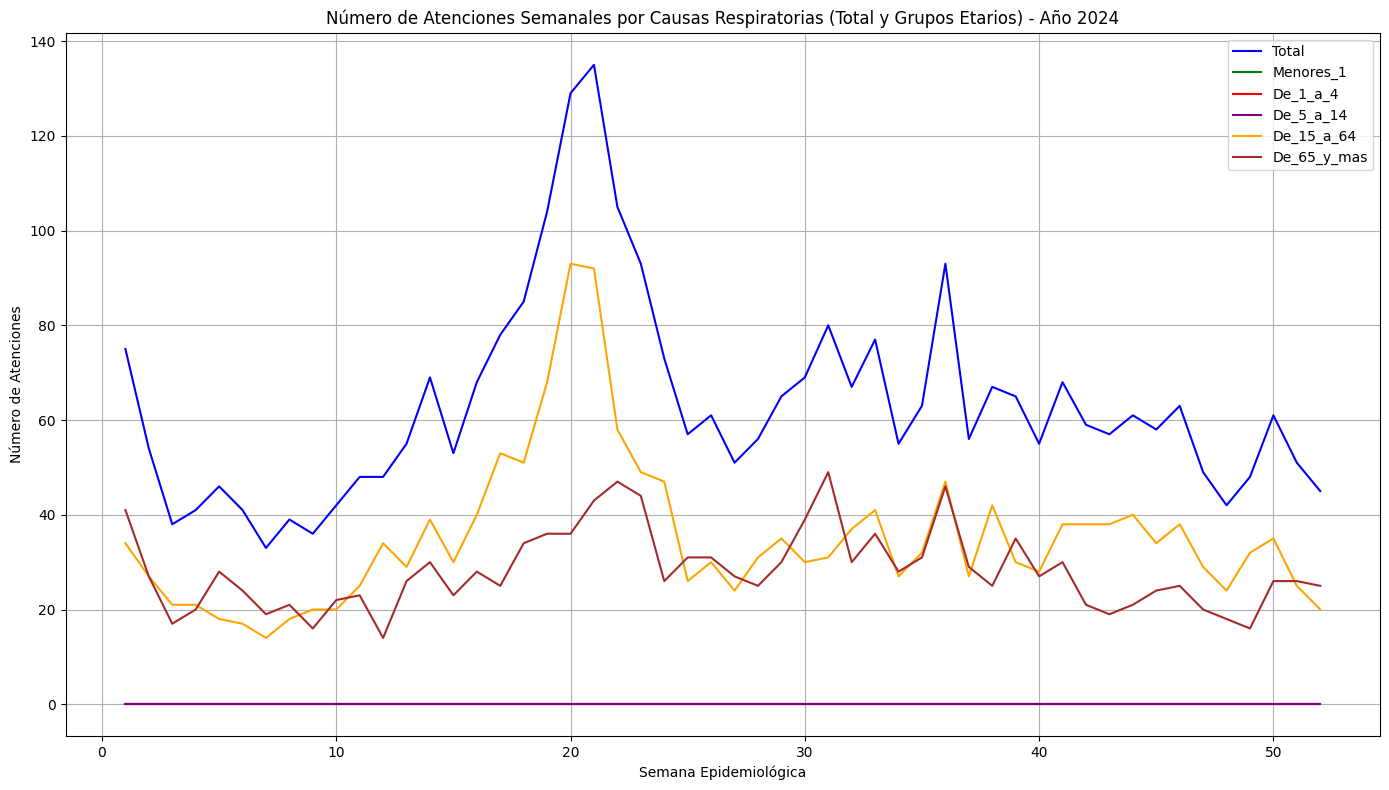


Tabla del Número de Atenciones Semanales por Grupo Etario - Año 2024:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          75          0         0          0          34           41
2          54          0         0          0          27           27
3          38          0         0          0          21           17
4          41          0         0          0          21           20
5          46          0         0          0          18           28
6          41          0         0          0          17           24
7          33          0         0          0          14           19
8          39          0         0          0          18           21
9          36          0         0          0          20           16
10         42          0         0          0          20           22
11         48          0         0          0          25           23
12    

In [20]:
# GRAFICO Y TABLA SEMANAL PARA 2024

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features_2024' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad_2024 = df_features_2024.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos para 2024
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad_2024.index, y=atenciones_semanales_edad_2024['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad_2024.index, y=atenciones_semanales_edad_2024['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad_2024.index, y=atenciones_semanales_edad_2024['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad_2024.index, y=atenciones_semanales_edad_2024['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad_2024.index, y=atenciones_semanales_edad_2024['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad_2024.index, y=atenciones_semanales_edad_2024['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios) - Año 2024')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario para 2024
print("\nTabla del Número de Atenciones Semanales por Grupo Etario - Año 2024:")
print(atenciones_semanales_edad_2024)

## 2025

### TODOS LOS DATOS

In [21]:
# Celda 1: Descomprimir el archivo ZIP
import zipfile
import os

zip_file_path = 'AtencionesUrgencia2025.zip'
extracted_dir = 'AtencionesUrgencia2025'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

csv_file_path = os.path.join(extracted_dir, 'AtencionesUrgencia2025.csv')
print(f"Archivo CSV extraído en: {csv_file_path}")

Archivo CSV extraído en: AtencionesUrgencia2025/AtencionesUrgencia2025.csv


In [22]:
# Celda 2: Leer el archivo CSV y crear el DataFrame
import pandas as pd

csv_file_path = 'AtencionesUrgencia2025/AtencionesUrgencia2025.csv'
ate_urg_2025 = pd.read_csv(csv_file_path, encoding="ISO-8859-1", delimiter=';')

In [23]:
# Celda 3: Mostrar ejemplo de datos
ate_urg_2025.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,...,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,CodigoRegion,NombreRegion,CodigoDependencia,NombreDependencia,CodigoComuna,NombreComuna
0,03-910,SAR Alemania,25,SECCIÓN 2. TOTAL DE HOSPITALIZACIONES,0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
1,03-910,SAR Alemania,7,CAUSAS SISTEMA RESPIRATORIO,0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
2,03-910,SAR Alemania,33,"- COVID-19, VIRUS NO IDENTIFICADO U07.2",0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
3,03-910,SAR Alemania,32,"- COVID-19, VIRUS IDENTIFICADO U07.1",0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
4,03-910,SAR Alemania,22,- CAUSAS SISTEMA CIRCULATORIO,0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
5,03-910,SAR Alemania,23,- TRAUMATISMOS Y ENVENENAMIENTOS,0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
6,03-910,SAR Alemania,42,- CAUSAS POR TRASTORNOS MENTALES (F00-F99),0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
7,03-910,SAR Alemania,24,CIRUGÍAS DE URGENCIA,0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
8,03-910,SAR Alemania,8,- LAS DEMÁS CAUSAS,0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama
9,03-910,SAR Alemania,27,Pacientes en espera de hospitalización,0,0,0,0,0,0,...,19,SAR,Indiferenciado,Ninguna,2.0,De Antofagasta,3.0,Antofagasta,2201.0,Calama


In [24]:
# Celda 4: Validar número de filas
num_filas = len(ate_urg_2025)
print(f"Hay {num_filas} filas.")

Hay 3309040 filas.


### HSO

In [25]:
# SOLO DATOS HOSPITAL

# Filtrar primero las filas donde 'NEstablecimiento' no es NaN
not_nan_establecimiento = ate_urg_2025[ate_urg_2025["NEstablecimiento"].notna()]

# Luego aplicar el filtro de contener "Tisné"
ate_urg_2025_hospital = not_nan_establecimiento[not_nan_establecimiento["NEstablecimiento"].str.contains("Tisné")]

In [26]:
# Celda para validar fechas dinámicamente según el DataFrame (error corregido)

import pandas as pd

def validar_fechas(df, columna_fecha="fecha"):
    """
    Valida si todas las fechas de un año están presentes en una columna de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columna_fecha (str, optional): El nombre de la columna que contiene las fechas.
                                       Por defecto es "fecha".
    """
    if columna_fecha not in df.columns:
        print(f"⚠️ Error: La columna '{columna_fecha}' no existe en el DataFrame.")
        return

    # Obtener las fechas únicas del DataFrame
    fechas_unicas = df[columna_fecha].unique()

    try:
        # Convertir las fechas a formato datetime
        fechas_en_df = pd.to_datetime(fechas_unicas, format="%d/%m/%Y")

        # Ordenar las fechas convertidas
        fechas_ordenadas = sorted(fechas_en_df)

        # Mostrar las fechas ordenadas en formato de lista vertical
        print(f"📅 Fechas ordenadas en el DataFrame (año {fechas_ordenadas[0].year if fechas_ordenadas else 'desconocido'}):")
        for fecha in fechas_ordenadas:
            print(fecha.strftime("%d/%m/%Y"))

        if not fechas_ordenadas:
            print("\n⚠️ No se encontraron fechas válidas en el DataFrame.")
            return

        # Obtener el año del primer registro de fecha
        año = fechas_ordenadas[0].year

        # Generar todas las fechas posibles del año
        rango_fechas_año = pd.date_range(start=f"01/01/{año}", end=f"31/12/{año}", freq="D")

        # Encontrar fechas faltantes
        fechas_faltantes = set(rango_fechas_año.date) - set(fechas_en_df.date)

        # Mostrar las fechas faltantes en formato vertical
        print(f"\n📌 Fechas faltantes en el DataFrame (año {año}):")
        if fechas_faltantes:
            for fecha in sorted(list(fechas_faltantes)):
                print(fecha.strftime("%d/%m/%Y"))
        else:
            print(f"✅ Todas las fechas de {año} están presentes en el DataFrame.")

    except ValueError as e:
        print(f"⚠️ Error al convertir las fechas: {e}. Asegúrate de que el formato sea dd/mm/aaaa en la columna '{columna_fecha}'.")

# Ejemplo de uso con tu DataFrame 'ate_urg_2025_hospital'
validar_fechas(ate_urg_2025_hospital)

📅 Fechas ordenadas en el DataFrame (año 2025):
01/01/2025
02/01/2025
03/01/2025
04/01/2025
05/01/2025
06/01/2025
07/01/2025
08/01/2025
09/01/2025
10/01/2025
11/01/2025
12/01/2025
13/01/2025
14/01/2025
15/01/2025
16/01/2025
17/01/2025
18/01/2025
19/01/2025
20/01/2025
21/01/2025
22/01/2025
23/01/2025
24/01/2025
25/01/2025
26/01/2025
27/01/2025
28/01/2025
29/01/2025
30/01/2025
31/01/2025
01/02/2025
02/02/2025
03/02/2025
04/02/2025
05/02/2025
06/02/2025
07/02/2025
08/02/2025
09/02/2025
10/02/2025
11/02/2025
12/02/2025
13/02/2025
14/02/2025
15/02/2025
16/02/2025
17/02/2025
18/02/2025
19/02/2025
20/02/2025
21/02/2025
22/02/2025
23/02/2025
24/02/2025
25/02/2025
26/02/2025
27/02/2025
28/02/2025
01/03/2025
02/03/2025
03/03/2025
04/03/2025
05/03/2025
06/03/2025
07/03/2025
08/03/2025
09/03/2025
10/03/2025
11/03/2025
12/03/2025
13/03/2025
14/03/2025
15/03/2025
16/03/2025
17/03/2025
18/03/2025
19/03/2025
20/03/2025
21/03/2025
22/03/2025
23/03/2025
24/03/2025
25/03/2025
26/03/2025
27/03/2025
28/03/2

In [27]:
# Validar número de filas
num_filas = len(ate_urg_2025_hospital)
print(f"Hay {num_filas} filas.")

Hay 5360 filas.


In [28]:
# Mostrar ejemplo de datos
ate_urg_2025_hospital.head(10)

,IdEstablecimiento,NEstablecimiento,IdCausa,GlosaCausa,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,...,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,CodigoRegion,NombreRegion,CodigoDependencia,NombreDependencia,CodigoComuna,NombreComuna
1106639,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",34,TOTAL DEMANDA,115,0,0,0,72,43,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106640,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,109,0,0,0,68,41,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106641,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",2,TOTAL CAUSAS SISTEMA RESPIRATORIO,5,0,0,0,4,1,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106642,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",10,IRA Alta (J00-J06),2,0,0,0,2,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106643,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",4,Influenza (J09-J11),0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106644,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",5,Neumonía (J12-J18),3,0,0,0,2,1,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106645,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",3,Bronquitis/bronquiolitis aguda (J20-J21),0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106646,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",11,Crisis obstructiva bronquial (J40-J46),0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106647,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén
1106648,12-101,"Hospital Dr. Luis Tisné B. (Santiago, Peñalolén)",31,"Covid-19, Virus no identificado U07.2",0,0,0,0,0,0,...,1,Hospital,Adulto,Adulto Metropolitana,13.0,Metropolitana de Santiago,12.0,Metropolitano Oriente,13122.0,Peñalolén


In [29]:
# Crear el DataFrame de features para el modelo del año 2025
df_features_2025 = ate_urg_2025_hospital.copy()

# 1. Filtrar por 'GlosaCausa' igual a "TOTAL CAUSAS SISTEMA RESPIRATORIO"
df_features_2025 = df_features_2025[df_features_2025['GlosaCausa'] == 'TOTAL CAUSAS SISTEMA RESPIRATORIO'].copy()
# Se añade .copy() para evitar SettingWithCopyWarning

# 2. Convierte la columna 'fecha' a datetime
df_features_2025['fecha'] = pd.to_datetime(df_features_2025['fecha'], format='%d/%m/%Y')

# 3. Crear nuevas características a partir de la columna 'fecha'
df_features_2025['año'] = df_features_2025['fecha'].dt.year
df_features_2025['mes'] = df_features_2025['fecha'].dt.month
df_features_2025['dia_del_mes'] = df_features_2025['fecha'].dt.day
df_features_2025['dia_de_la_semana'] = df_features_2025['fecha'].dt.dayofweek  # Lunes=0, Domingo=6
df_features_2025['dia_del_año'] = df_features_2025['fecha'].dt.dayofyear
df_features_2025['trimestre'] = df_features_2025['fecha'].dt.quarter
df_features_2025['fin_de_semana'] = (df_features_2025['fecha'].dt.dayofweek >= 5).astype(int)  # 1 si es sábado o domingo, 0 si no

# Nota: La columna 'semana' ya existe en tu DataFrame.

# 4. Establecer la columna 'fecha' como índice (después de crear las características)
df_features_2025 = df_features_2025.set_index('fecha')

# 5. Eliminar las columnas especificadas (después de crear las características)
columnas_a_eliminar = [
    'IdEstablecimiento',
    'IdCausa',
    'GLOSATIPOESTABLECIMIENTO',
    'GlosaTipoCampana',
    'CodigoRegion',
    'NombreRegion',
    'CodigoDependencia',
    'NombreDependencia',
    'CodigoComuna',
    'NombreComuna',
    'NEstablecimiento',
    'GlosaCausa',
    'GLOSATIPOATENCION'
]
df_features_2025 = df_features_2025.drop(columns=columnas_a_eliminar, errors='ignore')
# errors='ignore' evita que el código falle si alguna columna no existe

# Mostrar el nuevo DataFrame de features para 2025
#print("DataFrame 'df_features_2025' con nuevas características de fecha:")
df_features_2025.head()
#print("\nInformación del DataFrame 'df_features_2025':")
#df_features_2025.info()

,Total,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas,semana,año,mes,dia_del_mes,dia_de_la_semana,dia_del_año,trimestre,fin_de_semana
fecha,,,,,,,,,,,,,,
2025-01-01,5,0,0,0,4,1,1,2025,1,1,2,1,1,0
2025-01-02,5,0,0,0,3,2,1,2025,1,2,3,2,1,0
2025-01-03,6,0,0,0,3,3,1,2025,1,3,4,3,1,0
2025-01-04,4,0,0,0,3,1,1,2025,1,4,5,4,1,1
2025-01-05,7,0,0,0,4,3,2,2025,1,5,6,5,1,1


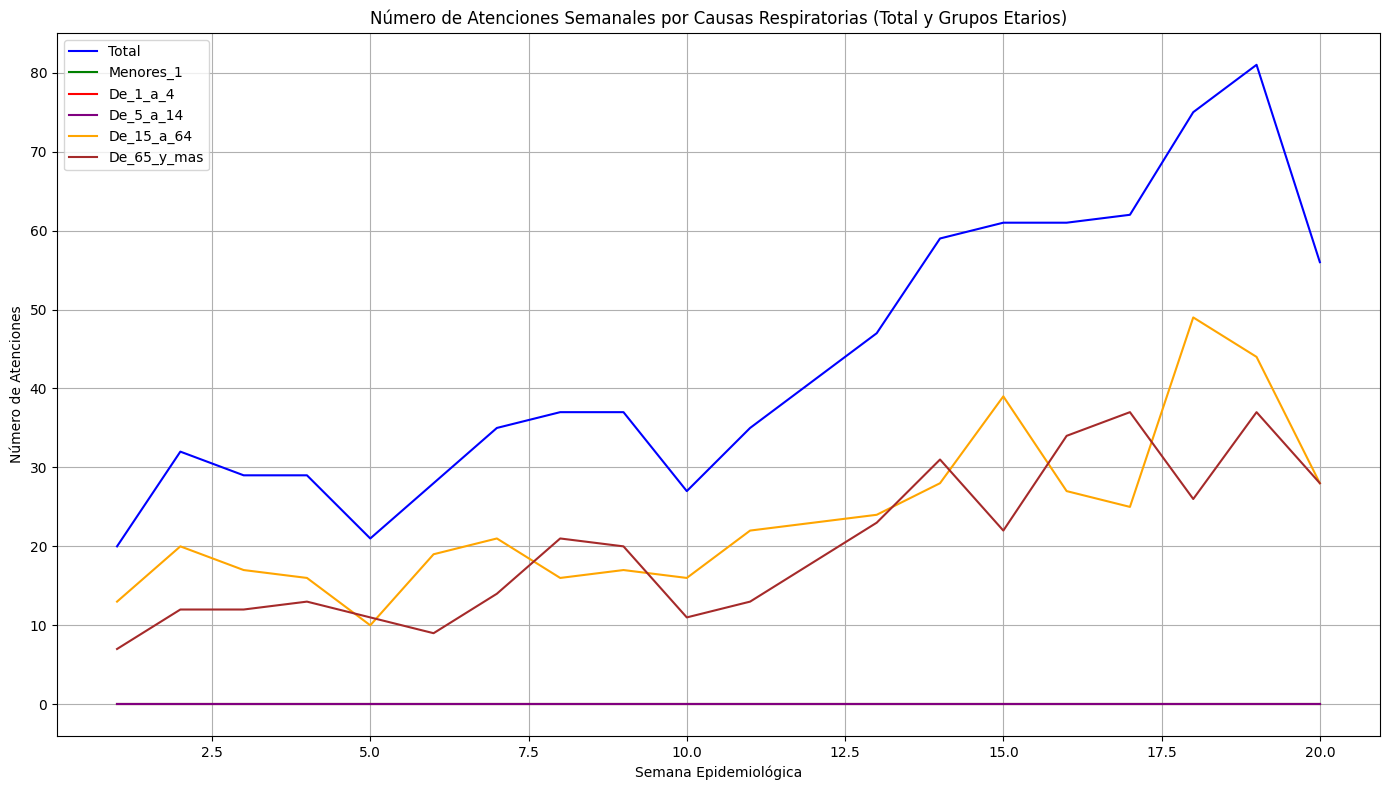


Tabla del Número de Atenciones Semanales por Grupo Etario:
        Total  Menores_1  De_1_a_4  De_5_a_14  De_15_a_64  De_65_y_mas
semana                                                                
1          20          0         0          0          13            7
2          32          0         0          0          20           12
3          29          0         0          0          17           12
4          29          0         0          0          16           13
5          21          0         0          0          10           11
6          28          0         0          0          19            9
7          35          0         0          0          21           14
8          37          0         0          0          16           21
9          37          0         0          0          17           20
10         27          0         0          0          16           11
11         35          0         0          0          22           13
12         41    

In [30]:
# GRAFICO Y TABLA SEMANAL

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_features' tenga la columna 'semana' y las columnas de grupos etarios.
# Los nombres de las columnas de grupos etarios son: 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas'.

# Agrupar por semana y sumar el total de atenciones y las atenciones por grupo etario
atenciones_semanales_edad = df_features_2025.groupby('semana')[['Total', 'Menores_1', 'De_1_a_4', 'De_5_a_14', 'De_15_a_64', 'De_65_y_mas']].sum()

# Crear el gráfico de serie de tiempo con todos los grupos
plt.figure(figsize=(14, 8))
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Total'], label='Total', color='blue')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['Menores_1'], label='Menores_1', color='green')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_1_a_4'], label='De_1_a_4', color='red')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_5_a_14'], label='De_5_a_14', color='purple')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_15_a_64'], label='De_15_a_64', color='orange')
sns.lineplot(x=atenciones_semanales_edad.index, y=atenciones_semanales_edad['De_65_y_mas'], label='De_65_y_mas', color='brown')

plt.title('Número de Atenciones Semanales por Causas Respiratorias (Total y Grupos Etarios)')
plt.xlabel('Semana Epidemiológica')
plt.ylabel('Número de Atenciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar la tabla del número de atenciones semanales por grupo etario
print("\nTabla del Número de Atenciones Semanales por Grupo Etario:")
print(atenciones_semanales_edad)